In [43]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns


import pickle

In [44]:

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Reading, extracting and slicing data (Psychopy and Shimmer)

In [45]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## Normalize  data

In [46]:
def normalize_data_min_max (std_df, signal_col):
    # std_df: data frame
    # signal_col: col of interest
    
    signal = std_df[signal_col].to_list()
    
    
    signal_float =[float(val) for val in signal]
    
    signal_float_np = np.array(signal_float)
    
    
    min_val = np.min(signal_float_np)
    max_val = np.max(signal_float_np)
    
    range_val = max_val-min_val
    
    
    min_sub = signal_float_np - min_val
    
    scaled_data = min_sub/range_val
    
    
    std_df["min_max_norm"] = scaled_data
    
    return std_df

In [47]:
def min_max_norm(all_rr_one_list, all_rr_sublist):
    
    mean_norm_list =[]
    std_norm_list = []
    
    all_rr_one_list = np.array(all_rr_one_list)
    max_val = np.max(all_rr_one_list)
    min_val =np.min(all_rr_one_list)
    
    for sel_list in all_rr_sublist:
        
        sel_list_np = np.array(sel_list)
        
        range_list = max_val-min_val
        
        sel_lis_np_sub = sel_list_np - min_val
        
        sel_lis_norm= sel_lis_np_sub/range_list
        
        mean_norm = np.mean(sel_lis_norm)
        mean_norm_list.append(mean_norm)
        
        std_norm  = np.std(sel_lis_norm)   
        std_norm_list.append(std_norm)
        #print(mean_norm)
        #print(std_norm)
                
        
    return mean_norm_list, std_norm_list

## Plotting data

In [48]:
def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig

## HRV: Time Domain Analysis

In [49]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
 



def filter_rr(rr, throshold_high=0.5, threshold_low=0.5):
    
    #outlier_high = np.mean(rr) + throshold_high * np.std(rr)
    outlier_high =1500
    #print(outlier_high)
    
    rr_clean_high = [rr_val for rr_val in rr if rr_val <  outlier_high]
    
    rr_clean_high = np.array(rr_clean_high)
    
    #outlier_low = np.mean(rr_clean_high) - threshold_low*np.std(rr_clean_high)
    outlier_low = 400
    #print(outlier_low)
    
    rr_clean_high_low = [rr_val for rr_val in rr_clean_high if rr_val >  outlier_low]
    
    rr_clean_high_low= np.array(rr_clean_high_low)
    
    return rr_clean_high_low



def remove_outliers_rri(r_peaks, sampling_freq = 256):
    
    # RR-intervals are the differences between successive peaks
    r_peaks_sec = r_peaks*1/sampling_freq
    r_peaks_msec = r_peaks_sec*1000

    r_peaks_diff=np.diff(r_peaks_msec)
    
    rr_corrected = r_peaks_diff.copy()

    rr_corrected[np.abs(zscore(r_peaks_diff)) > 2] = np.median(r_peaks_diff)
    
    return rr_corrected
    


        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## HRV: Frequency Domain

In [50]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Fetching info and calculate mean and standard deviation 

In [51]:
def get_mean_std_event_list(psychopy_df, shimmer_df_selected, event_interest_list_new, offset_min_list_new, timestamp_sensor_col_name, data_col_name):

    mean_cumm_list = []
    std_cumm_list  = []
    event_interets_plot = []
    
    all_rr_one_list = []
    all_rr_sublist = []
    
    
    
    
    


    ##---outer loop to handle muultiple offsets from the selected events 
    for ind, event_selected in enumerate(event_interest_list_new):

        offset_list_selected_event = offset_min_list_new[ind]

        #print(event_selected)

        current_event_timestamp = get_nonNan_list_psychopy(psychopy_df, event_selected)[0]

        offset_min_list_selected = offset_min_list_new[ind]
        
        acc_min_print = 0

        for offset_min in offset_min_list_selected:
            
            offset_min_print = offset_min + acc_min_print
            
            acc_min_print = offset_min_print

            event_plot = event_selected +" "+ str(offset_min_print) + " min"
            
            print(event_plot)
            
            event_interets_plot.append(event_plot)

            timestamp_offset = get_offset_timestamp(current_event_timestamp, offset_min)

            start_end_time_list = [current_event_timestamp, timestamp_offset]

            timestamp_start_slice = min(start_end_time_list)

            timestamp_end_slice = max(start_end_time_list)

            sensor_df_ii=slice_df_wrt_timestamps(shimmer_df_selected, timestamp_start_slice, timestamp_end_slice, timestamp_sensor_col_name)
            
            #print(sensor_df_ii)
            
            ecg_df_ii=sensor_df_ii.reset_index(drop=True)
            
            
            #cond_slice_main = (ecg_df_ii[timestamp_sensor_col_name] >= timestamp_start_slice) & (ecg_df_ii[timestamp_sensor_col_name] < timestamp_end_slice)
            
            #ecg_slice = ecg_df_ii.heartrate
            ecg_slice = ecg_df_ii[data_col_name].values
            out = ecg.ecg(signal=ecg_slice, sampling_rate=256, show=False,interactive=False)
            
            r_peaks = out["rpeaks"]
            r_peaks_diff = remove_outliers_rri(r_peaks, sampling_freq = 256)
            
            r_peaks_diff=filter_rr(r_peaks_diff)
            
            #r_peaks_sec = r_peaks*1/256
            #r_peaks_msec = r_peaks_sec*1000

            #r_peaks_diff=np.diff(r_peaks_msec)
            
            
            
            
            print(timedomain(r_peaks_diff))
            

            
            #peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
            #grouped_peaks = group_peaks(peaks)
            #grouped_peak_msec =group_peaks_from_ind_to_msec(grouped_peaks, 256)
            #rr = np.diff(grouped_peak_msec)
            #print(timedomain(rr))
            
            
            #cleaned_rr = filter_rr(r_peaks_diff)
            cleaned_rr=r_peaks_diff
            mean_rr = np.mean(cleaned_rr) 
            std_rr = np.std(cleaned_rr)
            
            mean_cumm_list.append(mean_rr)
            std_cumm_list.append(std_rr)
            
            all_rr_one_list.extend(cleaned_rr)
            all_rr_sublist.append(cleaned_rr)
            
            
            #event_interets_plot
            
            #print(np.mean(cleaned_rr))
            #print(np.std(cleaned_rr))
            


            current_event_timestamp = timestamp_offset
            
            
            
    return mean_cumm_list, std_cumm_list, event_interets_plot, all_rr_one_list, all_rr_sublist

## Paths and files

In [52]:
data_dir_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3"
#data_dir_path = "D:/Datasets/data_sony_digiRelax/study"
sub_dirs=next(os.walk(data_dir_path))[1]
sub_dirs=sorted(sub_dirs)

In [53]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts"]
offset_min_list_new  = [[3], [5], [5,5], [5, 5, 5]]

In [54]:
dest_path ="/home/muhammad/Desktop/repos_ixp/tester_sony_digirelax/scripts/wp4/results_all_sub/hrv/ibi_filtered_pkl"
#dest_path = "D:/Datasets/analysis_digirelax"
designated_folder = "hrv_analysis"
comp_dest_path = os.path.join(dest_path, designated_folder)

isexist = os.path.exists(comp_dest_path)

if not isexist:
    os.makedirs(comp_dest_path)
    print("The new directory is created")

The new directory is created


/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP004_081123/Psychopy_data/VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317.csv
VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1036.8595566860465, 'STD RR/SDNN (ms)': 40.90440401938423, 'Mean HR (beats/min)': 57.95725884977819, 'STD HR (beats/min)': 2.289199138183479, 'Min HR (beats/min)': 53.333333333333336, 'Max HR (beats/min)': 63.47107438016529, 'RMSSD (ms)': 37.6468156571174, 'NNxx': 34, 'pNNxx (%)': 19.767441860465116}
tsst_prep_ts 5 min
{'Mean RR (ms)': 1017.3519736842105, 'STD RR/SDNN (ms)': 79.52834134254704, 'Mean HR (beats/min)': 59.37372389002209, 'STD HR (beats/min)': 5.2323728151003035, 'Min HR (beats/min)': 50.19607843137255, 'Max HR (beats/min)': 105.93103448275862, 'RMSSD (ms)': 65.7782644757163, 'NNxx': 51, 'pNNxx (%)': 17.894736842105264}
tsst_pres_ts 5 min
{'Mean RR (ms)': 1014.3008474576271, 'STD RR/SDNN (ms)': 75.42545372569349, 'Mean HR (beat

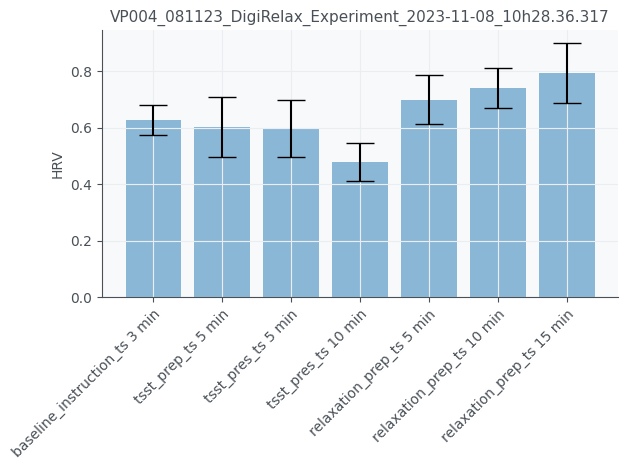

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv
VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226
baseline_instruction_ts 3 min
{'Mean RR (ms)': 916.6599548969073, 'STD RR/SDNN (ms)': 97.84502600238851, 'Mean HR (beats/min)': 66.25216821652971, 'STD HR (beats/min)': 7.4983239859157145, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 83.47826086956522, 'RMSSD (ms)': 76.63429639625014, 'NNxx': 100, 'pNNxx (%)': 51.54639175257732}
tsst_prep_ts 5 min
{'Mean RR (ms)': 644.0036083877995, 'STD RR/SDNN (ms)': 45.152496335724265, 'Mean HR (beats/min)': 93.61381829096918, 'STD HR (beats/min)': 6.39320028007061, 'Min HR (beats/min)': 78.76923076923077, 'Max HR (beats/min)': 109.71428571428571, 'RMSSD (ms)': 31.356430387798405, 'NNxx': 44, 'pNNxx (%)': 9.586056644880175}
tsst_pres_ts 5 min
{'Mean RR (ms)': 512.9390270506108, 'STD RR/SDNN (ms)': 49.08644909486449, 'Mean HR (beats

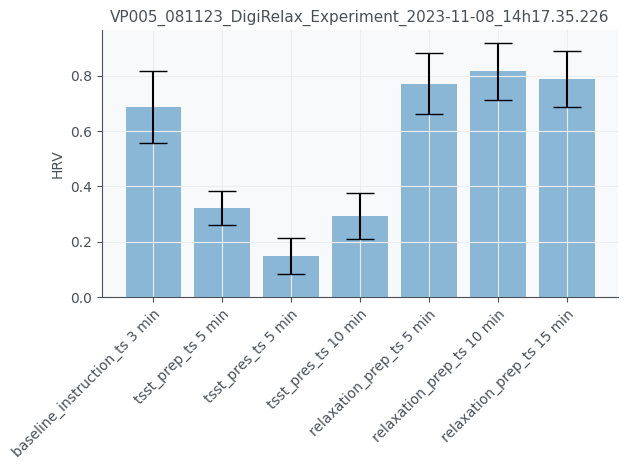

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP006_091123/Psychopy_data/VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415.csv
VP006_091123_DigiRelax_Experiment_2023-11-09_10h17.40.415
baseline_instruction_ts 3 min
{'Mean RR (ms)': 638.5108646953405, 'STD RR/SDNN (ms)': 24.735466711546195, 'Mean HR (beats/min)': 94.11043362727311, 'STD HR (beats/min)': 3.6663527584681317, 'Min HR (beats/min)': 84.86187845303867, 'Max HR (beats/min)': 106.66666666666667, 'RMSSD (ms)': 16.359479625849875, 'NNxx': 2, 'pNNxx (%)': 0.7168458781362007}
tsst_prep_ts 5 min
{'Mean RR (ms)': 604.7017332995952, 'STD RR/SDNN (ms)': 20.587543553497472, 'Mean HR (beats/min)': 99.33809598385477, 'STD HR (beats/min)': 3.3998080830317834, 'Min HR (beats/min)': 91.97604790419162, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 13.8526359108474, 'NNxx': 3, 'pNNxx (%)': 0.6072874493927125}
tsst_pres_ts 5 min
{'Mean RR (ms)': 559.9227561090225, 'STD RR/SDNN (ms)': 24.10677693326666, 'Mean HR (beat

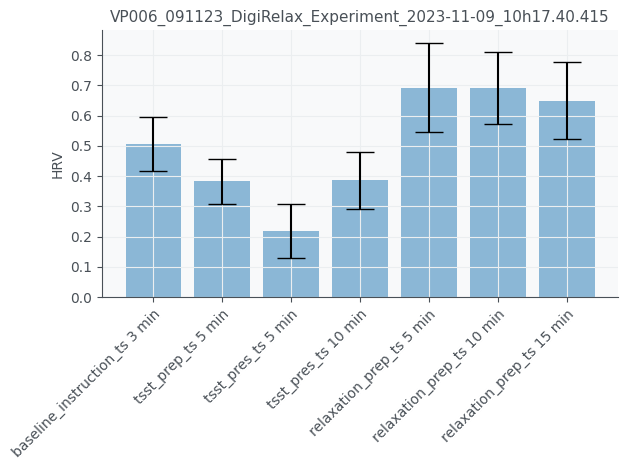

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP007_091123/Psychopy_data/VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411.csv
VP007_091123_DigiRelax_Experiment_2023-11-09_14h19.56.411
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1228.3674568965516, 'STD RR/SDNN (ms)': 26.044893032402012, 'Mean HR (beats/min)': 48.86731941634104, 'STD HR (beats/min)': 1.0379386634591798, 'Min HR (beats/min)': 46.54545454545455, 'Max HR (beats/min)': 51.029900332225914, 'RMSSD (ms)': 22.60202517817702, 'NNxx': 5, 'pNNxx (%)': 3.4482758620689653}
tsst_prep_ts 5 min
{'Mean RR (ms)': 1082.5812274368232, 'STD RR/SDNN (ms)': 40.84757388759919, 'Mean HR (beats/min)': 55.50326253346148, 'STD HR (beats/min)': 2.12688264398918, 'Min HR (beats/min)': 51.717171717171716, 'Max HR (beats/min)': 60.71146245059288, 'RMSSD (ms)': 24.051025917506223, 'NNxx': 12, 'pNNxx (%)': 4.332129963898917}
tsst_pres_ts 5 min
{'Mean RR (ms)': 998.1849747474747, 'STD RR/SDNN (ms)': 60.70941884155133, 'Mean HR (beat

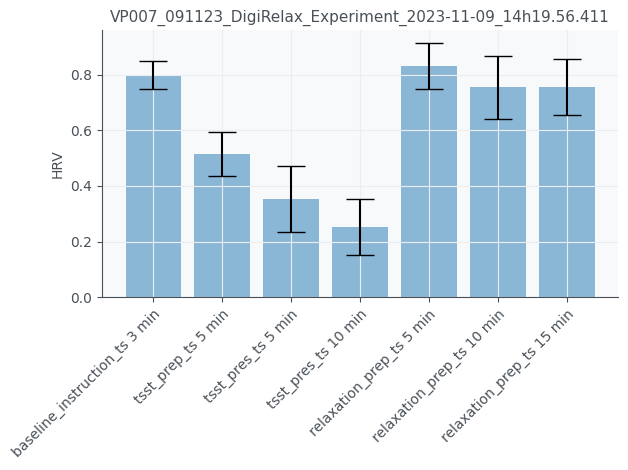

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP008_101123/Psychopy_data/VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323.csv
VP008_101123_DigiRelax_Experiment_2023-11-10_10h24.14.323
baseline_instruction_ts 3 min
{'Mean RR (ms)': 931.937172774869, 'STD RR/SDNN (ms)': 88.15876745682642, 'Mean HR (beats/min)': 64.96905386359006, 'STD HR (beats/min)': 6.233923915975774, 'Min HR (beats/min)': 54.275618374558306, 'Max HR (beats/min)': 78.76923076923077, 'RMSSD (ms)': 68.257383971949, 'NNxx': 86, 'pNNxx (%)': 45.026178010471206}
tsst_prep_ts 5 min
{'Mean RR (ms)': 818.8705234159779, 'STD RR/SDNN (ms)': 89.55449943009411, 'Mean HR (beats/min)': 74.18130650855976, 'STD HR (beats/min)': 8.391505255373138, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 96.0, 'RMSSD (ms)': 55.344106026444834, 'NNxx': 95, 'pNNxx (%)': 26.170798898071624}
tsst_pres_ts 5 min
{'Mean RR (ms)': 797.6770833333334, 'STD RR/SDNN (ms)': 56.99634681580235, 'Mean HR (beats/min)': 75.607061

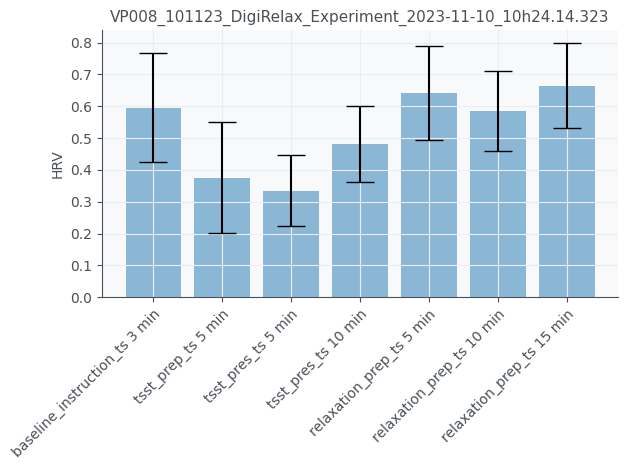

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP009_101123/Psychopy_data/VP009_101123_DigiRelax_Experiment_2023-11-10_14h16.47.223.csv
VP009_101123_DigiRelax_Experiment_2023-11-10_14h16.47.223
baseline_instruction_ts 3 min
{'Mean RR (ms)': 917.1029317010309, 'STD RR/SDNN (ms)': 50.00826507541145, 'Mean HR (beats/min)': 65.61806945540476, 'STD HR (beats/min)': 3.576086677991628, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 73.49282296650718, 'RMSSD (ms)': 40.79504629111763, 'NNxx': 50, 'pNNxx (%)': 25.77319587628866}
tsst_prep_ts 5 min
{'Mean RR (ms)': 702.0537825059101, 'STD RR/SDNN (ms)': 73.24594322159875, 'Mean HR (beats/min)': 86.42335919385172, 'STD HR (beats/min)': 9.265436059533243, 'Min HR (beats/min)': 69.81818181818181, 'Max HR (beats/min)': 108.93617021276596, 'RMSSD (ms)': 42.26068299735573, 'NNxx': 82, 'pNNxx (%)': 19.38534278959811}
tsst_pres_ts 5 min
{'Mean RR (ms)': 562.7763503824092, 'STD RR/SDNN (ms)': 49.764894402379475, 'Mean HR (beats/mi

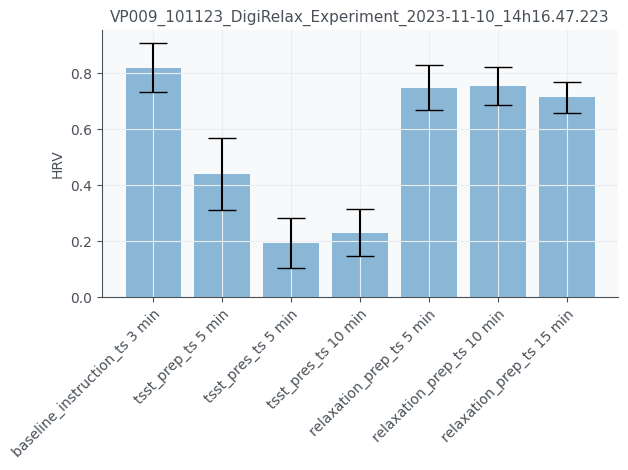

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP010_131123/Psychopy_data/VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913.csv
VP010_131123_DigiRelax_Experiment_2023-11-13_09h54.08.913
baseline_instruction_ts 3 min
{'Mean RR (ms)': 741.5364583333334, 'STD RR/SDNN (ms)': 68.8596986980816, 'Mean HR (beats/min)': 81.60859747816652, 'STD HR (beats/min)': 7.518261872177621, 'Min HR (beats/min)': 67.07423580786026, 'Max HR (beats/min)': 96.0, 'RMSSD (ms)': 44.73013273181374, 'NNxx': 61, 'pNNxx (%)': 25.416666666666668}
tsst_prep_ts 5 min
{'Mean RR (ms)': 557.3648174157304, 'STD RR/SDNN (ms)': 62.23085346486306, 'Mean HR (beats/min)': 109.01565057705714, 'STD HR (beats/min)': 12.298529265947451, 'Min HR (beats/min)': 87.27272727272727, 'Max HR (beats/min)': 135.92920353982302, 'RMSSD (ms)': 19.755687488912958, 'NNxx': 9, 'pNNxx (%)': 1.6853932584269662}
tsst_pres_ts 5 min
{'Mean RR (ms)': 493.4565355329949, 'STD RR/SDNN (ms)': 35.91212483063788, 'Mean HR (beats/min)': 122.23

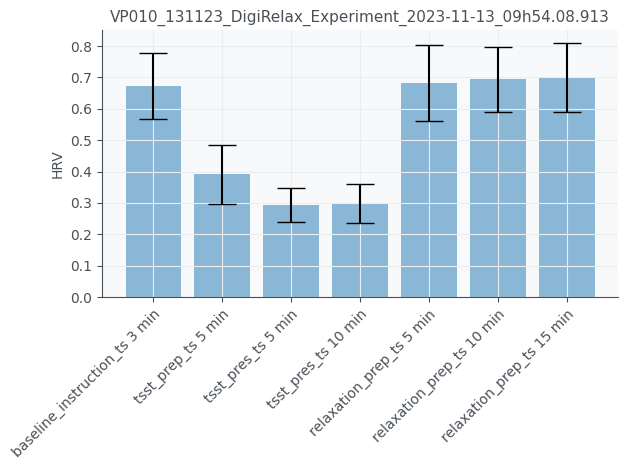

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP011_131123/Psychopy_data/VP011_131123_DigiRelax_Experiment_2023-11-13_14h42.51.249.csv
VP011_131123_DigiRelax_Experiment_2023-11-13_14h42.51.249
baseline_instruction_ts 3 min
{'Mean RR (ms)': 881.4132462686567, 'STD RR/SDNN (ms)': 72.7190435041315, 'Mean HR (beats/min)': 68.52684204915856, 'STD HR (beats/min)': 5.532284020661013, 'Min HR (beats/min)': 57.100371747211895, 'Max HR (beats/min)': 81.26984126984127, 'RMSSD (ms)': 79.21986716421345, 'NNxx': 124, 'pNNxx (%)': 61.691542288557216}
tsst_prep_ts 5 min
{'Mean RR (ms)': 659.7821547884187, 'STD RR/SDNN (ms)': 64.40001586080704, 'Mean HR (beats/min)': 91.81505088366143, 'STD HR (beats/min)': 9.025230484169276, 'Min HR (beats/min)': 74.20289855072464, 'Max HR (beats/min)': 110.50359712230215, 'RMSSD (ms)': 31.307168167793833, 'NNxx': 33, 'pNNxx (%)': 7.349665924276169}
tsst_pres_ts 5 min
{'Mean RR (ms)': 655.4618209534368, 'STD RR/SDNN (ms)': 57.0061737315713, 'Mean HR (beats/m

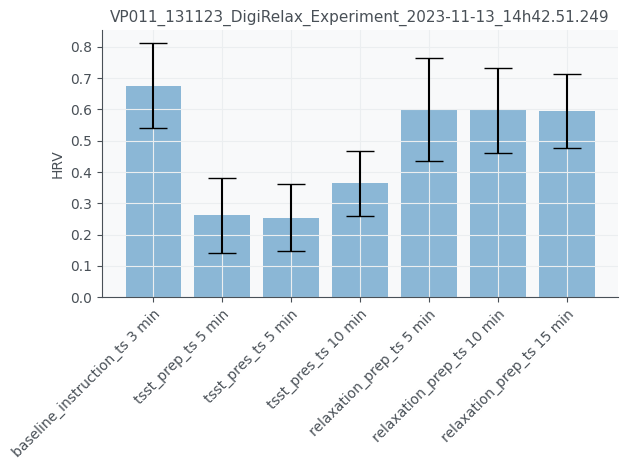

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP012_141123/Psychopy_data/VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508.csv
VP012_141123_DigiRelax_Experiment_2023-11-14_09h47.48.508
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1084.7301136363637, 'STD RR/SDNN (ms)': 65.59796377521859, 'Mean HR (beats/min)': 55.518195686436385, 'STD HR (beats/min)': 3.396010072164146, 'Min HR (beats/min)': 49.073482428115014, 'Max HR (beats/min)': 63.7344398340249, 'RMSSD (ms)': 71.95790304340423, 'NNxx': 104, 'pNNxx (%)': 63.03030303030303}
tsst_prep_ts 5 min
{'Mean RR (ms)': 901.3466591591591, 'STD RR/SDNN (ms)': 83.23575833280464, 'Mean HR (beats/min)': 67.16623580144854, 'STD HR (beats/min)': 6.538755181183571, 'Min HR (beats/min)': 54.46808510638298, 'Max HR (beats/min)': 86.29213483146067, 'RMSSD (ms)': 71.52214421273376, 'NNxx': 170, 'pNNxx (%)': 51.051051051051054}
tsst_pres_ts 5 min
{'Mean RR (ms)': 796.5929979946524, 'STD RR/SDNN (ms)': 78.84989431331165, 'Mean HR (beats

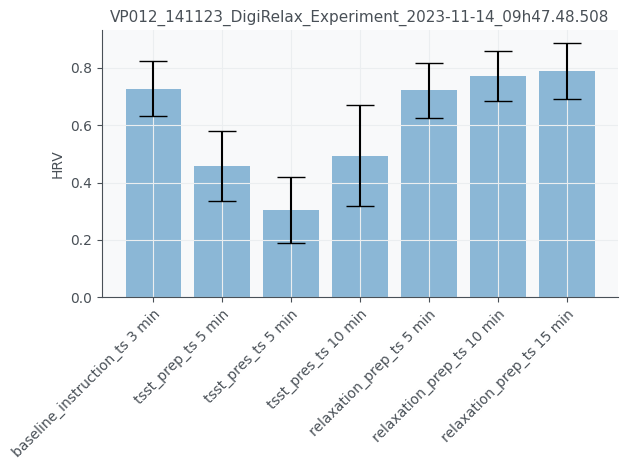

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP013_151123/Psychopy_data/VP013_151123_DigiRelax_Experiment_2023-11-15_09h52.50.734.csv
VP013_151123_DigiRelax_Experiment_2023-11-15_09h52.50.734
baseline_instruction_ts 3 min
{'Mean RR (ms)': 596.9484060402684, 'STD RR/SDNN (ms)': 13.387492757393328, 'Mean HR (beats/min)': 100.56271086484769, 'STD HR (beats/min)': 2.298197995894616, 'Min HR (beats/min)': 95.40372670807453, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 9.514473526790821, 'NNxx': 0, 'pNNxx (%)': 0.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 575.8104699803149, 'STD RR/SDNN (ms)': 24.84269495761472, 'Mean HR (beats/min)': 104.38712589710308, 'STD HR (beats/min)': 4.354655774010583, 'Min HR (beats/min)': 78.76923076923077, 'Max HR (beats/min)': 130.16949152542372, 'RMSSD (ms)': 31.344719770414656, 'NNxx': 30, 'pNNxx (%)': 5.905511811023622}
tsst_pres_ts 5 min
{'Mean RR (ms)': 556.1882062146892, 'STD RR/SDNN (ms)': 25.38319797499325, 'Mean HR (beats/min)': 108.09

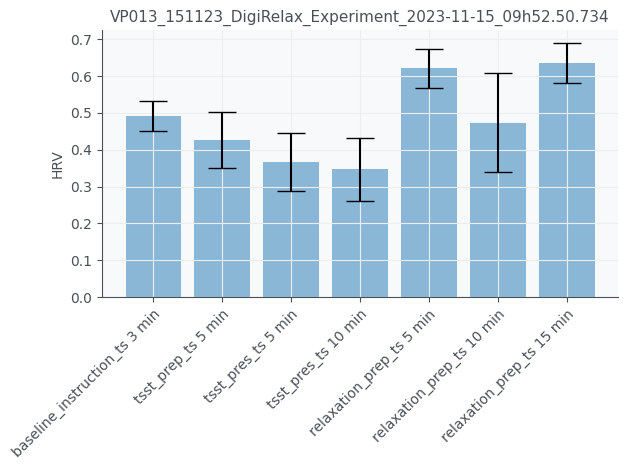

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP014_151123/Psychopy_data/VP014_151123_DigiRelax_Experiment_2023-11-15_14h23.06.117.csv
VP014_151123_DigiRelax_Experiment_2023-11-15_14h23.06.117
baseline_instruction_ts 3 min
{'Mean RR (ms)': 737.4903150826447, 'STD RR/SDNN (ms)': 42.72673683081062, 'Mean HR (beats/min)': 81.63029220204592, 'STD HR (beats/min)': 4.732813652937896, 'Min HR (beats/min)': 70.45871559633028, 'Max HR (beats/min)': 96.60377358490567, 'RMSSD (ms)': 37.37098798964372, 'NNxx': 39, 'pNNxx (%)': 16.115702479338843}
tsst_prep_ts 5 min
{'Mean RR (ms)': 677.6773174157304, 'STD RR/SDNN (ms)': 71.36510094496118, 'Mean HR (beats/min)': 89.52422133474408, 'STD HR (beats/min)': 9.47768954065056, 'Min HR (beats/min)': 67.66519823788546, 'Max HR (beats/min)': 130.16949152542372, 'RMSSD (ms)': 56.228355543074585, 'NNxx': 117, 'pNNxx (%)': 26.292134831460675}
tsst_pres_ts 5 min
{'Mean RR (ms)': 685.3237907925408, 'STD RR/SDNN (ms)': 64.69894583105999, 'Mean HR (beats/

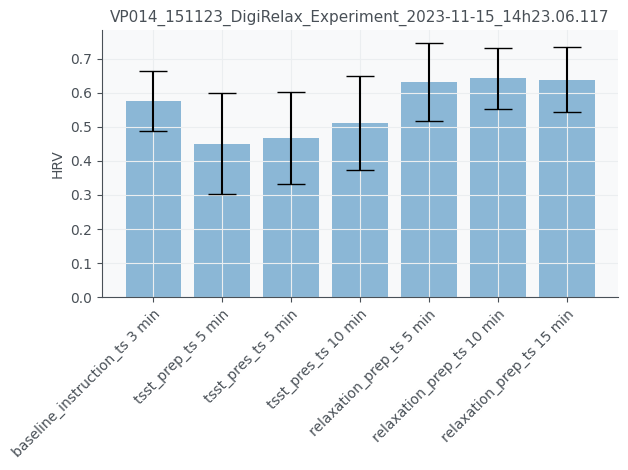

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP015_161123/Psychopy_data/VP015_161123_DigiRelax_Experiment_2023-11-16_09h47.53.124.csv
VP015_161123_DigiRelax_Experiment_2023-11-16_09h47.53.124
baseline_instruction_ts 3 min
{'Mean RR (ms)': 836.5033586448598, 'STD RR/SDNN (ms)': 30.521066136292898, 'Mean HR (beats/min)': 71.82353586427526, 'STD HR (beats/min)': 2.644015469173672, 'Min HR (beats/min)': 66.49350649350649, 'Max HR (beats/min)': 77.96954314720813, 'RMSSD (ms)': 27.114861935589705, 'NNxx': 15, 'pNNxx (%)': 7.009345794392523}
tsst_prep_ts 5 min
{'Mean RR (ms)': 676.1701074660633, 'STD RR/SDNN (ms)': 52.08195534511415, 'Mean HR (beats/min)': 89.26859676839898, 'STD HR (beats/min)': 6.96498915311769, 'Min HR (beats/min)': 75.29411764705883, 'Max HR (beats/min)': 108.93617021276596, 'RMSSD (ms)': 30.725202961244, 'NNxx': 30, 'pNNxx (%)': 6.787330316742081}
tsst_pres_ts 5 min
{'Mean RR (ms)': 564.176245210728, 'STD RR/SDNN (ms)': 51.721160573459585, 'Mean HR (beats/min)

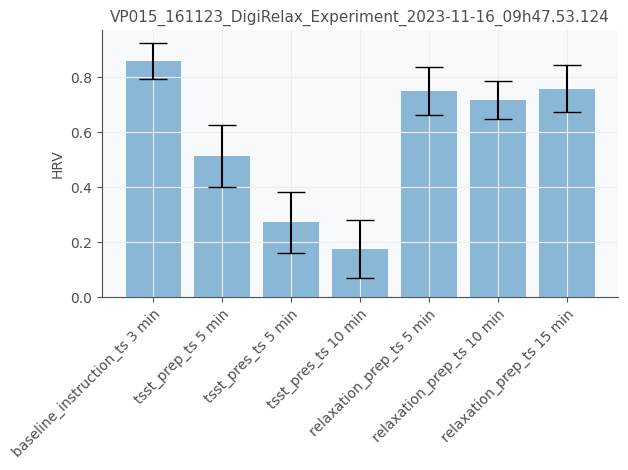

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP016_161123/Psychopy_data/VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355.csv
VP016_161123_DigiRelax_Experiment_2023-11-16_14h46.57.355
baseline_instruction_ts 3 min
{'Mean RR (ms)': 727.8539540816327, 'STD RR/SDNN (ms)': 17.1603384497772, 'Mean HR (beats/min)': 82.4800813056017, 'STD HR (beats/min)': 1.9503934622183454, 'Min HR (beats/min)': 77.96954314720813, 'Max HR (beats/min)': 87.77142857142857, 'RMSSD (ms)': 15.178362903668196, 'NNxx': 0, 'pNNxx (%)': 0.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 680.0992127249357, 'STD RR/SDNN (ms)': 208.04541777469674, 'Mean HR (beats/min)': 104.45513573213786, 'STD HR (beats/min)': 134.1415099260034, 'Min HR (beats/min)': 36.57142857142857, 'Max HR (beats/min)': 2560.0, 'RMSSD (ms)': 276.96865346045564, 'NNxx': 154, 'pNNxx (%)': 39.588688946015424}
tsst_pres_ts 5 min
{'Mean RR (ms)': 666.0201777389277, 'STD RR/SDNN (ms)': 58.546458132282474, 'Mean HR (beats/min)': 90.81569828898877

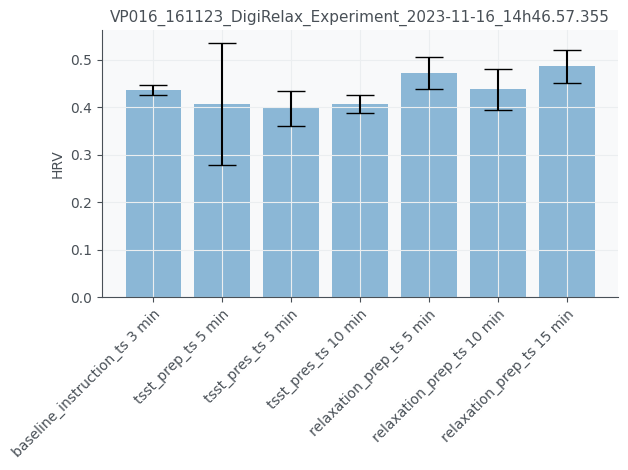

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP017_171123/Psychopy_data/VP017_171123_DigiRelax_Experiment_2023-11-17_14h43.13.415.csv
VP017_171123_DigiRelax_Experiment_2023-11-17_14h43.13.415
baseline_instruction_ts 3 min
{'Mean RR (ms)': 974.7481215846994, 'STD RR/SDNN (ms)': 79.75038155516609, 'Mean HR (beats/min)': 61.97617590551766, 'STD HR (beats/min)': 5.17759903424443, 'Min HR (beats/min)': 52.602739726027394, 'Max HR (beats/min)': 74.20289855072464, 'RMSSD (ms)': 69.43418918477592, 'NNxx': 98, 'pNNxx (%)': 53.55191256830601}
tsst_prep_ts 5 min
{'Mean RR (ms)': 680.896362586605, 'STD RR/SDNN (ms)': 67.85860302460621, 'Mean HR (beats/min)': 88.97129767381192, 'STD HR (beats/min)': 8.61016243428609, 'Min HR (beats/min)': 70.78341013824885, 'Max HR (beats/min)': 112.11678832116789, 'RMSSD (ms)': 51.11644569605985, 'NNxx': 102, 'pNNxx (%)': 23.556581986143186}
tsst_pres_ts 5 min
{'Mean RR (ms)': 714.2369538834952, 'STD RR/SDNN (ms)': 94.04504430070646, 'Mean HR (beats/min

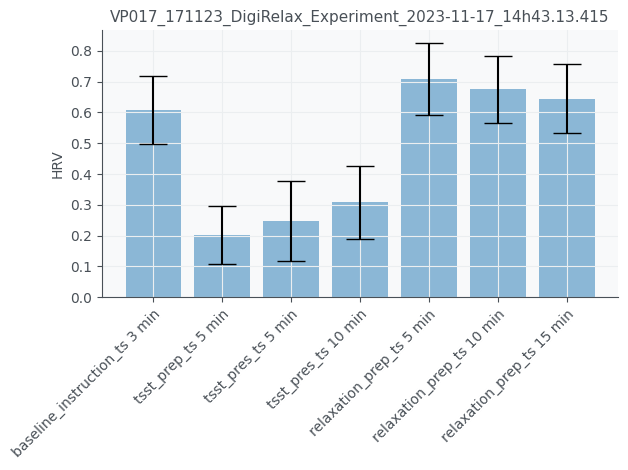

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP018_201123/Psychopy_data/VP018_201123_DigiRelax_Experiment_2023-11-20_09h51.59.612.csv
VP018_201123_DigiRelax_Experiment_2023-11-20_09h51.59.612
baseline_instruction_ts 3 min
{'Mean RR (ms)': 694.8835784313726, 'STD RR/SDNN (ms)': 30.684728843390126, 'Mean HR (beats/min)': 86.509692144547, 'STD HR (beats/min)': 3.7287558251195256, 'Min HR (beats/min)': 74.20289855072464, 'Max HR (beats/min)': 96.60377358490567, 'RMSSD (ms)': 26.84375723293331, 'NNxx': 15, 'pNNxx (%)': 5.882352941176471}
tsst_prep_ts 5 min
{'Mean RR (ms)': 686.4019297235023, 'STD RR/SDNN (ms)': 42.48147176199009, 'Mean HR (beats/min)': 87.74647113910538, 'STD HR (beats/min)': 5.432952901186346, 'Min HR (beats/min)': 71.44186046511628, 'Max HR (beats/min)': 110.50359712230215, 'RMSSD (ms)': 33.48148772797429, 'NNxx': 37, 'pNNxx (%)': 8.525345622119815}
tsst_pres_ts 5 min
{'Mean RR (ms)': 672.2921723300971, 'STD RR/SDNN (ms)': 49.786670342363344, 'Mean HR (beats/mi

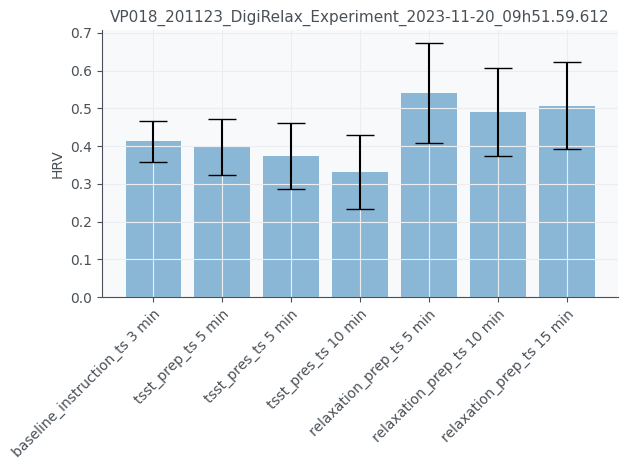

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP019_201123/Psychopy_data/VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367.csv
VP019_201123_DigiRelax_Experiment_2023-11-20_14h48.37.367
baseline_instruction_ts 3 min
{'Mean RR (ms)': 921.3917525773196, 'STD RR/SDNN (ms)': 18.32844108522828, 'Mean HR (beats/min)': 65.14488423397282, 'STD HR (beats/min)': 1.3076281597161676, 'Min HR (beats/min)': 62.4390243902439, 'Max HR (beats/min)': 68.57142857142857, 'RMSSD (ms)': 16.09851641651565, 'NNxx': 0, 'pNNxx (%)': 0.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 805.1731418918919, 'STD RR/SDNN (ms)': 29.299536113011023, 'Mean HR (beats/min)': 74.61651993253146, 'STD HR (beats/min)': 2.7065220201357927, 'Min HR (beats/min)': 68.57142857142857, 'Max HR (beats/min)': 81.26984126984127, 'RMSSD (ms)': 21.579199537134098, 'NNxx': 11, 'pNNxx (%)': 2.972972972972973}
tsst_pres_ts 5 min
{'Mean RR (ms)': 751.9580447103275, 'STD RR/SDNN (ms)': 48.27954565261144, 'Mean HR (beats/min)': 80.130882

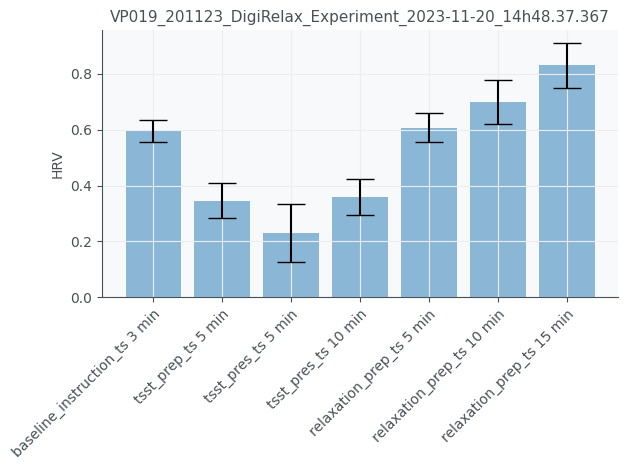

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP020_221123/Psychopy_data/VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766.csv
VP020_221123_DigiRelax_Experiment_2023-11-22_09h48.04.766
baseline_instruction_ts 3 min
{'Mean RR (ms)': 959.691722972973, 'STD RR/SDNN (ms)': 66.78596709860962, 'Mean HR (beats/min)': 62.82382349081921, 'STD HR (beats/min)': 4.37856169788174, 'Min HR (beats/min)': 54.08450704225352, 'Max HR (beats/min)': 72.79620853080569, 'RMSSD (ms)': 66.9138210792556, 'NNxx': 81, 'pNNxx (%)': 43.78378378378378}
tsst_prep_ts 5 min
{'Mean RR (ms)': 788.1921419098143, 'STD RR/SDNN (ms)': 60.81269120505096, 'Mean HR (beats/min)': 76.57924830074168, 'STD HR (beats/min)': 5.938868418700066, 'Min HR (beats/min)': 63.20987654320987, 'Max HR (beats/min)': 94.23312883435582, 'RMSSD (ms)': 50.40585984237813, 'NNxx': 95, 'pNNxx (%)': 25.19893899204244}
tsst_pres_ts 5 min
{'Mean RR (ms)': 698.669862412178, 'STD RR/SDNN (ms)': 64.00380491750231, 'Mean HR (beats/min)': 8

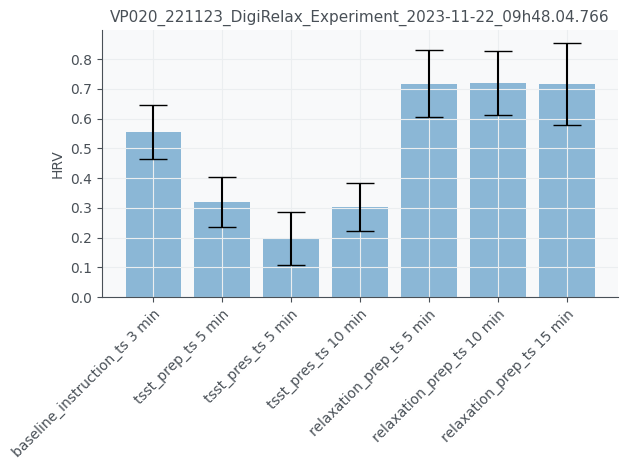

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP021_221123/Psychopy_data/VP021_221123_DigiRelax_Experiment_2023-11-22_14h43.57.344.csv
VP021_221123_DigiRelax_Experiment_2023-11-22_14h43.57.344
baseline_instruction_ts 3 min
{'Mean RR (ms)': 688.265625, 'STD RR/SDNN (ms)': 56.006087925917704, 'Mean HR (beats/min)': 87.69560011524517, 'STD HR (beats/min)': 6.434659631795103, 'Min HR (beats/min)': 66.78260869565217, 'Max HR (beats/min)': 102.4, 'RMSSD (ms)': 58.6334788336989, 'NNxx': 56, 'pNNxx (%)': 22.4}
tsst_prep_ts 5 min
{'Mean RR (ms)': 602.9253296146045, 'STD RR/SDNN (ms)': 32.29812015325274, 'Mean HR (beats/min)': 99.79826560968661, 'STD HR (beats/min)': 5.304175882095017, 'Min HR (beats/min)': 87.27272727272727, 'Max HR (beats/min)': 112.94117647058823, 'RMSSD (ms)': 20.708906569232262, 'NNxx': 15, 'pNNxx (%)': 3.0425963488843815}
tsst_pres_ts 5 min
{'Mean RR (ms)': 538.7346031021898, 'STD RR/SDNN (ms)': 40.52221668680031, 'Mean HR (beats/min)': 111.9851347654539, 'STD HR

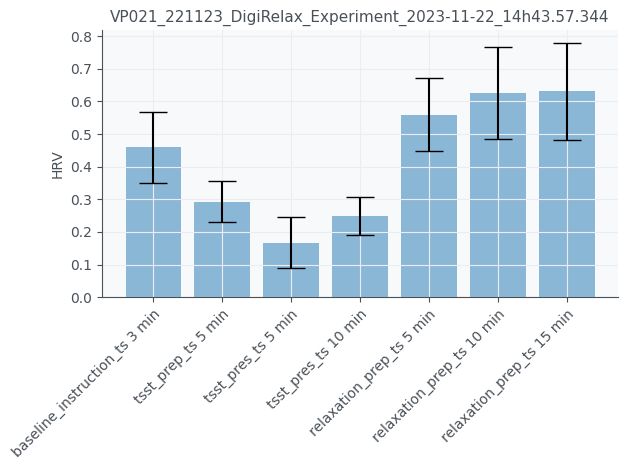

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP022_231123/Psychopy_data/VP022_231123_DigiRelax_Experiment_2023-11-23_09h47.27.026.csv
VP022_231123_DigiRelax_Experiment_2023-11-23_09h47.27.026
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1253.3326048951049, 'STD RR/SDNN (ms)': 65.00386037042091, 'Mean HR (beats/min)': 48.00458698585093, 'STD HR (beats/min)': 2.555174503925902, 'Min HR (beats/min)': 43.146067415730336, 'Max HR (beats/min)': 54.661921708185055, 'RMSSD (ms)': 96.6864255325551, 'NNxx': 89, 'pNNxx (%)': 62.23776223776224}
tsst_prep_ts 5 min
{'Mean RR (ms)': 903.9302884615385, 'STD RR/SDNN (ms)': 81.91308673907682, 'Mean HR (beats/min)': 66.92198796588171, 'STD HR (beats/min)': 6.059265406388932, 'Min HR (beats/min)': 53.89473684210526, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 69.99059597135975, 'NNxx': 150, 'pNNxx (%)': 46.15384615384615}
tsst_pres_ts 5 min
{'Mean RR (ms)': 719.5829503676471, 'STD RR/SDNN (ms)': 135.9996803594268, 'Mean HR (beats/mi

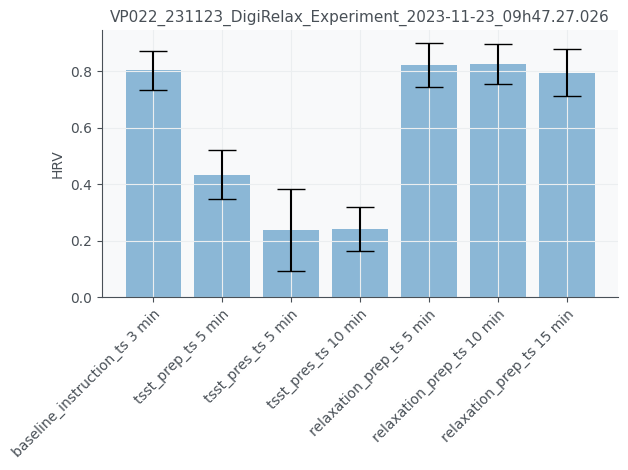

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP023_231123/Psychopy_data/VP023_231123_DigiRelax_Experiment_2023-11-23_14h49.16.111.csv
VP023_231123_DigiRelax_Experiment_2023-11-23_14h49.16.111
baseline_instruction_ts 3 min
{'Mean RR (ms)': 854.940368357488, 'STD RR/SDNN (ms)': 88.7081055344309, 'Mean HR (beats/min)': 70.94361805141017, 'STD HR (beats/min)': 7.413023654440524, 'Min HR (beats/min)': 57.3134328358209, 'Max HR (beats/min)': 90.88757396449704, 'RMSSD (ms)': 105.66871887060454, 'NNxx': 130, 'pNNxx (%)': 62.80193236714976}
tsst_prep_ts 5 min
{'Mean RR (ms)': 613.5345842050209, 'STD RR/SDNN (ms)': 45.56236591861563, 'Mean HR (beats/min)': 98.32689859042364, 'STD HR (beats/min)': 7.2363818094175, 'Min HR (beats/min)': 77.96954314720813, 'Max HR (beats/min)': 130.16949152542372, 'RMSSD (ms)': 39.327341841474215, 'NNxx': 81, 'pNNxx (%)': 16.94560669456067}
tsst_pres_ts 5 min
{'Mean RR (ms)': 512.9060813848921, 'STD RR/SDNN (ms)': 37.8491696845464, 'Mean HR (beats/min)':

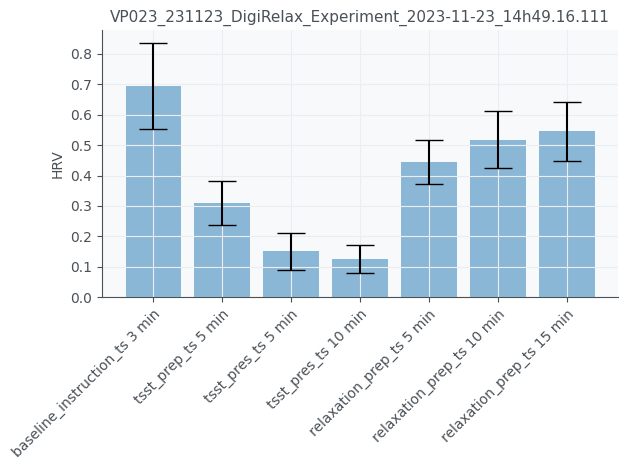

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP024_241123/Psychopy_data/VP024_241123_DigiRelax_Experiment_2023-11-24_15h57.15.078.csv
VP024_241123_DigiRelax_Experiment_2023-11-24_15h57.15.078
baseline_instruction_ts 3 min
{'Mean RR (ms)': 678.5245706106871, 'STD RR/SDNN (ms)': 28.768573387652687, 'Mean HR (beats/min)': 88.58317421839662, 'STD HR (beats/min)': 3.6854680271195694, 'Min HR (beats/min)': 78.76923076923077, 'Max HR (beats/min)': 97.8343949044586, 'RMSSD (ms)': 26.71979850791618, 'NNxx': 14, 'pNNxx (%)': 5.343511450381679}
tsst_prep_ts 5 min
{'Mean RR (ms)': 646.2053571428571, 'STD RR/SDNN (ms)': 43.70560619085166, 'Mean HR (beats/min)': 93.26018338804309, 'STD HR (beats/min)': 6.0995841993539575, 'Min HR (beats/min)': 76.8, 'Max HR (beats/min)': 110.50359712230215, 'RMSSD (ms)': 35.11463901262046, 'NNxx': 50, 'pNNxx (%)': 10.989010989010989}
tsst_pres_ts 5 min
{'Mean RR (ms)': 574.8220318532818, 'STD RR/SDNN (ms)': 30.84279212411765, 'Mean HR (beats/min)': 104.68

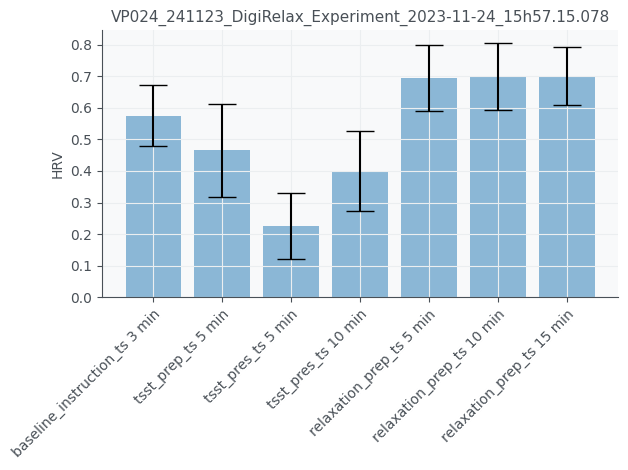

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP025_271123/Psychopy_data/VP025_271123_DigiRelax_Experiment_2023-11-27_09h46.03.287.csv
VP025_271123_DigiRelax_Experiment_2023-11-27_09h46.03.287
baseline_instruction_ts 3 min
{'Mean RR (ms)': 927.2170608108108, 'STD RR/SDNN (ms)': 56.54936103647084, 'Mean HR (beats/min)': 64.95495996636966, 'STD HR (beats/min)': 4.034928157730269, 'Min HR (beats/min)': 55.85454545454545, 'Max HR (beats/min)': 77.96954314720813, 'RMSSD (ms)': 56.09776633465696, 'NNxx': 77, 'pNNxx (%)': 41.62162162162162}
tsst_prep_ts 5 min
{'Mean RR (ms)': 644.650655021834, 'STD RR/SDNN (ms)': 36.665492691907524, 'Mean HR (beats/min)': 93.36514399213195, 'STD HR (beats/min)': 5.141114367242353, 'Min HR (beats/min)': 77.57575757575758, 'Max HR (beats/min)': 104.48979591836735, 'RMSSD (ms)': 27.847688060960035, 'NNxx': 22, 'pNNxx (%)': 4.8034934497816595}
tsst_pres_ts 5 min
{'Mean RR (ms)': 607.215811353211, 'STD RR/SDNN (ms)': 128.19894014898455, 'Mean HR (beats/m

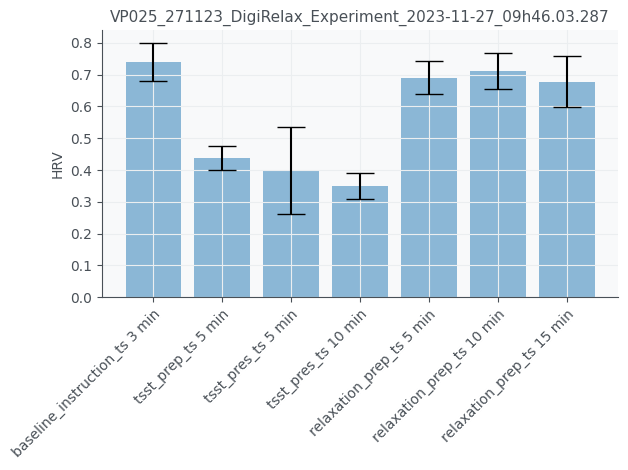

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP026_271123/Psychopy_data/VP26_271123_DigiRelax_Experiment_2023-11-27_13h16.52.357.csv
VP26_271123_DigiRelax_Experiment_2023-11-27_13h16.52.357
baseline_instruction_ts 3 min
{'Mean RR (ms)': 758.1948138297872, 'STD RR/SDNN (ms)': 274.0784600308051, 'Mean HR (beats/min)': 94.52954541493345, 'STD HR (beats/min)': 46.34520518403954, 'Min HR (beats/min)': 46.972477064220186, 'Max HR (beats/min)': 196.92307692307693, 'RMSSD (ms)': 359.8424733857541, 'NNxx': 212, 'pNNxx (%)': 90.2127659574468}
tsst_prep_ts 5 min
{'Mean RR (ms)': 765.6518286401099, 'STD RR/SDNN (ms)': 358.8215675151558, 'Mean HR (beats/min)': 100.65389180549131, 'STD HR (beats/min)': 58.97578568260946, 'Min HR (beats/min)': 35.88785046728972, 'Max HR (beats/min)': 465.45454545454544, 'RMSSD (ms)': 500.0798185337666, 'NNxx': 309, 'pNNxx (%)': 84.89010989010988}
tsst_pres_ts 5 min
{'Mean RR (ms)': 687.5764058679706, 'STD RR/SDNN (ms)': 276.12157935923557, 'Mean HR (beats/

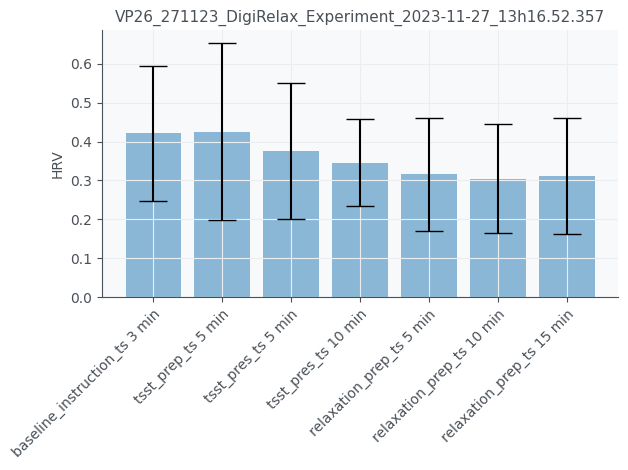

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP027_271123/Psychopy_data/VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227.csv
VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227
baseline_instruction_ts 3 min
{'Mean RR (ms)': 789.952641039823, 'STD RR/SDNN (ms)': 32.51999125860874, 'Mean HR (beats/min)': 76.08414058406993, 'STD HR (beats/min)': 3.1667535748625166, 'Min HR (beats/min)': 69.81818181818181, 'Max HR (beats/min)': 83.93442622950819, 'RMSSD (ms)': 25.210700646418644, 'NNxx': 13, 'pNNxx (%)': 5.752212389380531}
tsst_prep_ts 5 min
{'Mean RR (ms)': 751.6447368421053, 'STD RR/SDNN (ms)': 44.06386328417312, 'Mean HR (beats/min)': 80.10222869720032, 'STD HR (beats/min)': 4.744057980650888, 'Min HR (beats/min)': 70.13698630136986, 'Max HR (beats/min)': 93.65853658536585, 'RMSSD (ms)': 31.368777489747973, 'NNxx': 37, 'pNNxx (%)': 9.273182957393484}
tsst_pres_ts 5 min
{'Mean RR (ms)': 770.8063471502591, 'STD RR/SDNN (ms)': 44.46209323651723, 'Mean HR (beats/mi

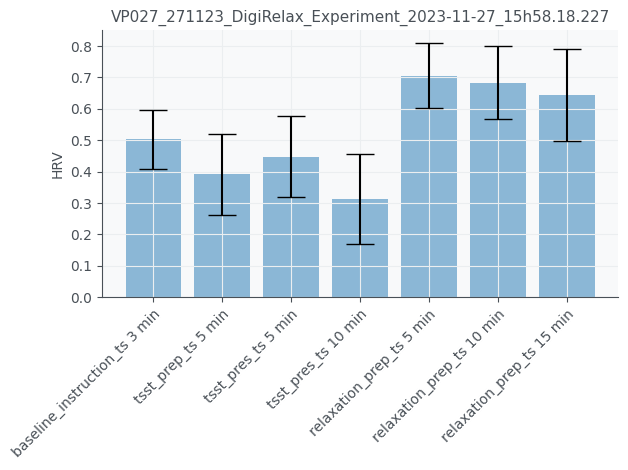

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP028_281123/Psychopy_data/VP028_281123_DigiRelax_Experiment_2023-11-28_13h11.36.660.csv
VP028_281123_DigiRelax_Experiment_2023-11-28_13h11.36.660
baseline_instruction_ts 3 min
{'Mean RR (ms)': 857.0574162679426, 'STD RR/SDNN (ms)': 57.55624940367145, 'Mean HR (beats/min)': 70.32730718600544, 'STD HR (beats/min)': 4.784158288246354, 'Min HR (beats/min)': 61.44, 'Max HR (beats/min)': 81.70212765957447, 'RMSSD (ms)': 53.83167701033093, 'NNxx': 93, 'pNNxx (%)': 44.49760765550239}
tsst_prep_ts 5 min
{'Mean RR (ms)': 661.593130506608, 'STD RR/SDNN (ms)': 42.70023452038309, 'Mean HR (beats/min)': 91.06513656191972, 'STD HR (beats/min)': 5.835230480578039, 'Min HR (beats/min)': 76.41791044776119, 'Max HR (beats/min)': 117.25190839694656, 'RMSSD (ms)': 31.7981468241911, 'NNxx': 35, 'pNNxx (%)': 7.709251101321586}
tsst_pres_ts 5 min
{'Mean RR (ms)': 663.3353221957041, 'STD RR/SDNN (ms)': 182.2227905984255, 'Mean HR (beats/min)': 95.9574992

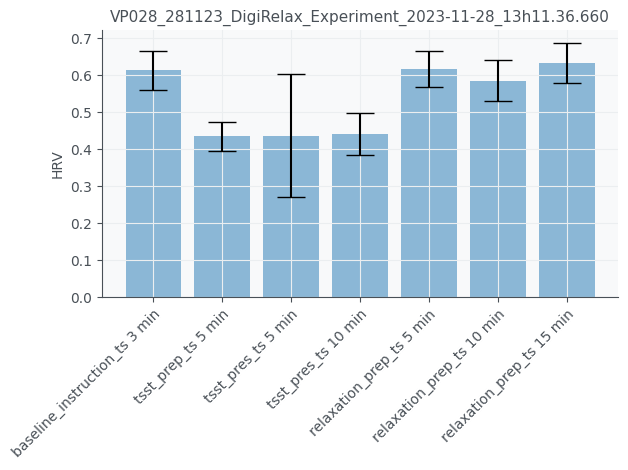

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP029_281123/Psychopy_data/VP029_281123_DigiRelax_Experiment_2023-11-28_15h49.00.382.csv
VP029_281123_DigiRelax_Experiment_2023-11-28_15h49.00.382
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1276.255580357143, 'STD RR/SDNN (ms)': 54.10054081588896, 'Mean HR (beats/min)': 47.0974197849684, 'STD HR (beats/min)': 2.005509436372293, 'Min HR (beats/min)': 42.90502793296089, 'Max HR (beats/min)': 52.42320819112628, 'RMSSD (ms)': 79.15796426831805, 'NNxx': 76, 'pNNxx (%)': 54.285714285714285}
tsst_prep_ts 5 min
{'Mean RR (ms)': 916.2567515432099, 'STD RR/SDNN (ms)': 105.8827121939656, 'Mean HR (beats/min)': 66.39189486946846, 'STD HR (beats/min)': 7.961884197570166, 'Min HR (beats/min)': 49.23076923076923, 'Max HR (beats/min)': 95.40372670807453, 'RMSSD (ms)': 64.71763480490239, 'NNxx': 126, 'pNNxx (%)': 38.888888888888886}
tsst_pres_ts 5 min
{'Mean RR (ms)': 813.3981128808864, 'STD RR/SDNN (ms)': 92.54703370897539, 'Mean HR (beats/mi

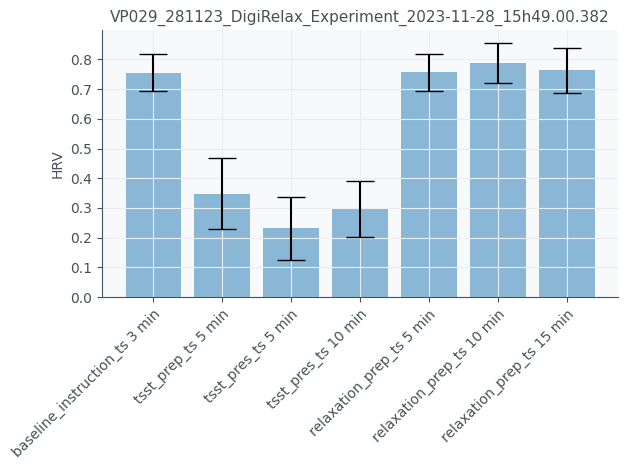

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP030_291123/Psychopy_data/VP030_291123_DigiRelax_Experiment_2023-11-29_09h54.53.886.csv
VP030_291123_DigiRelax_Experiment_2023-11-29_09h54.53.886
baseline_instruction_ts 3 min
{'Mean RR (ms)': 808.1143465909091, 'STD RR/SDNN (ms)': 42.879626033804314, 'Mean HR (beats/min)': 74.45592803008728, 'STD HR (beats/min)': 3.946664545760809, 'Min HR (beats/min)': 66.49350649350649, 'Max HR (beats/min)': 83.47826086956522, 'RMSSD (ms)': 39.7704469400001, 'NNxx': 53, 'pNNxx (%)': 24.09090909090909}
tsst_prep_ts 5 min
{'Mean RR (ms)': 602.9513888888889, 'STD RR/SDNN (ms)': 40.46466325310455, 'Mean HR (beats/min)': 99.97132943130414, 'STD HR (beats/min)': 6.8944986807066035, 'Min HR (beats/min)': 85.81005586592178, 'Max HR (beats/min)': 118.15384615384616, 'RMSSD (ms)': 20.400688834331863, 'NNxx': 15, 'pNNxx (%)': 3.0303030303030303}
tsst_pres_ts 5 min
{'Mean RR (ms)': 509.98787715517244, 'STD RR/SDNN (ms)': 32.70501529609451, 'Mean HR (beats

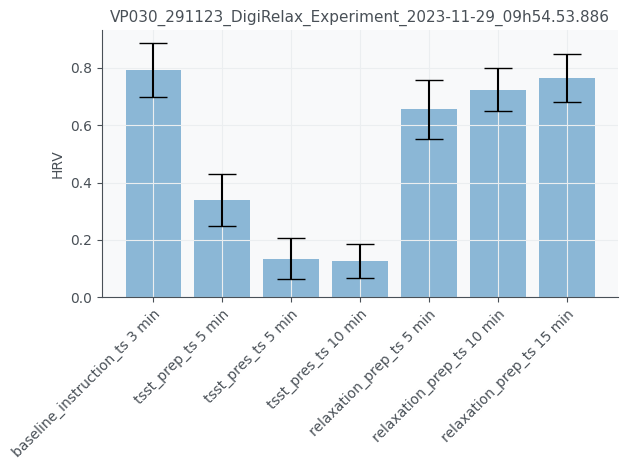

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP031_291123/Psychopy_data/VP031_291123_DigiRelax_Experiment_2023-11-29_14h41.15.470.csv
VP031_291123_DigiRelax_Experiment_2023-11-29_14h41.15.470
baseline_instruction_ts 3 min
{'Mean RR (ms)': 913.9429209183673, 'STD RR/SDNN (ms)': 57.99130684708177, 'Mean HR (beats/min)': 65.91833118075385, 'STD HR (beats/min)': 4.2490247547449895, 'Min HR (beats/min)': 57.100371747211895, 'Max HR (beats/min)': 77.57575757575758, 'RMSSD (ms)': 66.01032044194118, 'NNxx': 94, 'pNNxx (%)': 47.95918367346939}
tsst_prep_ts 5 min
{'Mean RR (ms)': 844.2231514084507, 'STD RR/SDNN (ms)': 69.45937826749662, 'Mean HR (beats/min)': 71.56414767724975, 'STD HR (beats/min)': 6.026671027860058, 'Min HR (beats/min)': 59.53488372093023, 'Max HR (beats/min)': 88.78612716763006, 'RMSSD (ms)': 62.2692265796775, 'NNxx': 148, 'pNNxx (%)': 41.690140845070424}
tsst_pres_ts 5 min
{'Mean RR (ms)': 720.2065677966102, 'STD RR/SDNN (ms)': 55.26631287662167, 'Mean HR (beats/m

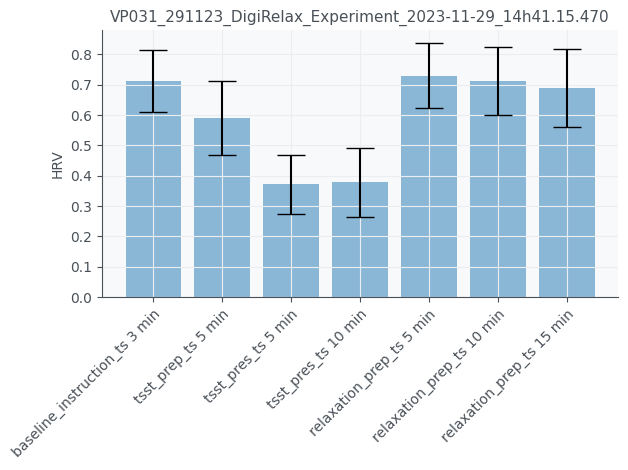

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP032_301123/Psychopy_data/VP032_301123_DigiRelax_Experiment_2023-11-30_09h49.51.787.csv
VP032_301123_DigiRelax_Experiment_2023-11-30_09h49.51.787
baseline_instruction_ts 3 min
{'Mean RR (ms)': 750.3475900423729, 'STD RR/SDNN (ms)': 75.8878969414531, 'Mean HR (beats/min)': 80.7436407733759, 'STD HR (beats/min)': 7.760983404936157, 'Min HR (beats/min)': 62.950819672131146, 'Max HR (beats/min)': 96.60377358490567, 'RMSSD (ms)': 66.42775778108981, 'NNxx': 89, 'pNNxx (%)': 37.71186440677966}
tsst_prep_ts 5 min
{'Mean RR (ms)': 560.875472589792, 'STD RR/SDNN (ms)': 21.10801217762333, 'Mean HR (beats/min)': 107.12379040272612, 'STD HR (beats/min)': 3.94325806408101, 'Min HR (beats/min)': 94.81481481481481, 'Max HR (beats/min)': 120.0, 'RMSSD (ms)': 15.959879076784905, 'NNxx': 10, 'pNNxx (%)': 1.890359168241966}
tsst_pres_ts 5 min
{'Mean RR (ms)': 511.39266304347825, 'STD RR/SDNN (ms)': 48.652331114422864, 'Mean HR (beats/min)': 118.3646

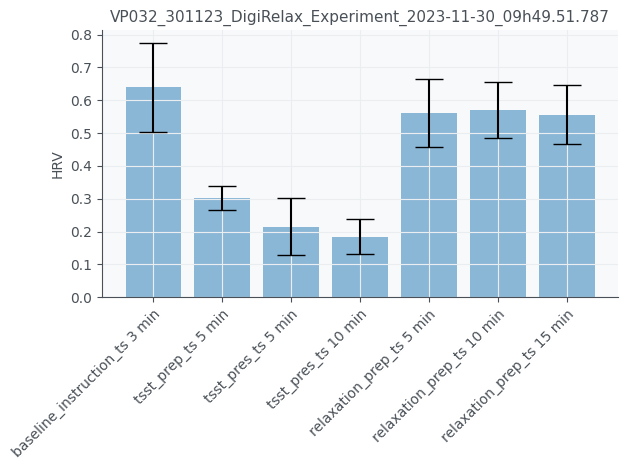

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP033_301123/Psychopy_data/VP033_301123_DigiRelax_Experiment_2023-11-30_15h44.58.284.csv
VP033_301123_DigiRelax_Experiment_2023-11-30_15h44.58.284
baseline_instruction_ts 3 min
{'Mean RR (ms)': 768.7195616883117, 'STD RR/SDNN (ms)': 53.95425472659208, 'Mean HR (beats/min)': 78.43497713172637, 'STD HR (beats/min)': 5.478607914737947, 'Min HR (beats/min)': 66.78260869565217, 'Max HR (beats/min)': 93.0909090909091, 'RMSSD (ms)': 51.01521666142592, 'NNxx': 88, 'pNNxx (%)': 38.095238095238095}
tsst_prep_ts 5 min
{'Mean RR (ms)': 628.9310253699789, 'STD RR/SDNN (ms)': 54.737906732016135, 'Mean HR (beats/min)': 96.12164796285032, 'STD HR (beats/min)': 8.337235789164394, 'Min HR (beats/min)': 77.96954314720813, 'Max HR (beats/min)': 116.36363636363636, 'RMSSD (ms)': 36.93473345942833, 'NNxx': 73, 'pNNxx (%)': 15.433403805496829}
tsst_pres_ts 5 min
{'Mean RR (ms)': 600.4215263691683, 'STD RR/SDNN (ms)': 63.4704981422253, 'Mean HR (beats/mi

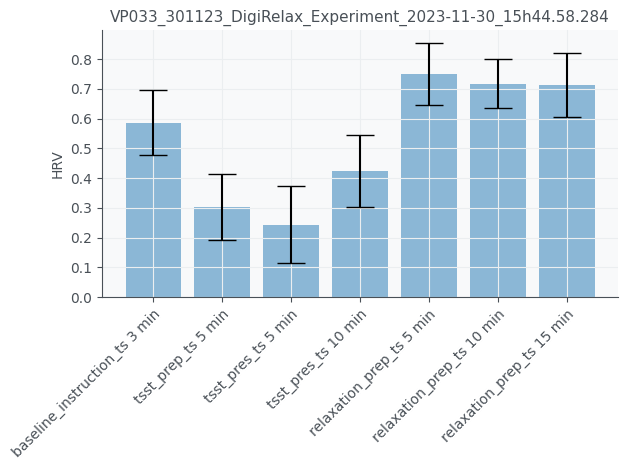

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP034_011223/Psychopy_data/VP034_011223_DigiRelax_Experiment_2023-12-01_14h41.10.723.csv
VP034_011223_DigiRelax_Experiment_2023-12-01_14h41.10.723
baseline_instruction_ts 3 min
{'Mean RR (ms)': 941.796875, 'STD RR/SDNN (ms)': 46.424905291359266, 'Mean HR (beats/min)': 63.86456658543238, 'STD HR (beats/min)': 3.182905943234509, 'Min HR (beats/min)': 56.888888888888886, 'Max HR (beats/min)': 73.14285714285714, 'RMSSD (ms)': 44.68107656317063, 'NNxx': 47, 'pNNxx (%)': 24.736842105263158}
tsst_prep_ts 5 min
{'Mean RR (ms)': 644.734172077922, 'STD RR/SDNN (ms)': 79.5665571091142, 'Mean HR (beats/min)': 94.43358478699, 'STD HR (beats/min)': 11.22079159662184, 'Min HR (beats/min)': 71.11111111111111, 'Max HR (beats/min)': 133.56521739130434, 'RMSSD (ms)': 48.96004751973969, 'NNxx': 83, 'pNNxx (%)': 17.965367965367964}
tsst_pres_ts 5 min
{'Mean RR (ms)': 581.4863703339882, 'STD RR/SDNN (ms)': 64.88928464570759, 'Mean HR (beats/min)': 104.

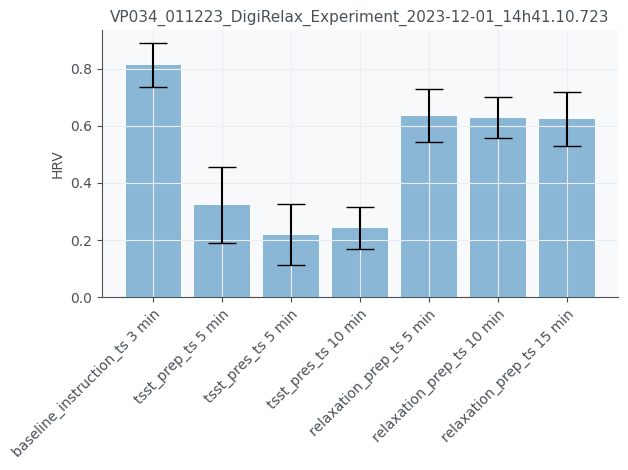

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP035_041223/Psychopy_data/VP035_041123_DigiRelax_Experiment_2023-12-04_09h54.08.642.csv
VP035_041123_DigiRelax_Experiment_2023-12-04_09h54.08.642
baseline_instruction_ts 3 min
{'Mean RR (ms)': 912.2796474358975, 'STD RR/SDNN (ms)': 65.74864075746528, 'Mean HR (beats/min)': 66.1199866658144, 'STD HR (beats/min)': 4.881983057630678, 'Min HR (beats/min)': 56.888888888888886, 'Max HR (beats/min)': 78.36734693877551, 'RMSSD (ms)': 62.79190952359133, 'NNxx': 87, 'pNNxx (%)': 44.61538461538461}
tsst_prep_ts 5 min
{'Mean RR (ms)': 644.4802989130435, 'STD RR/SDNN (ms)': 69.22753307544825, 'Mean HR (beats/min)': 94.18063278353017, 'STD HR (beats/min)': 10.160453348982731, 'Min HR (beats/min)': 72.11267605633803, 'Max HR (beats/min)': 123.87096774193549, 'RMSSD (ms)': 79.08145293197111, 'NNxx': 241, 'pNNxx (%)': 52.391304347826086}
tsst_pres_ts 5 min
{'Mean RR (ms)': 592.2545109832636, 'STD RR/SDNN (ms)': 106.90197854713256, 'Mean HR (beats

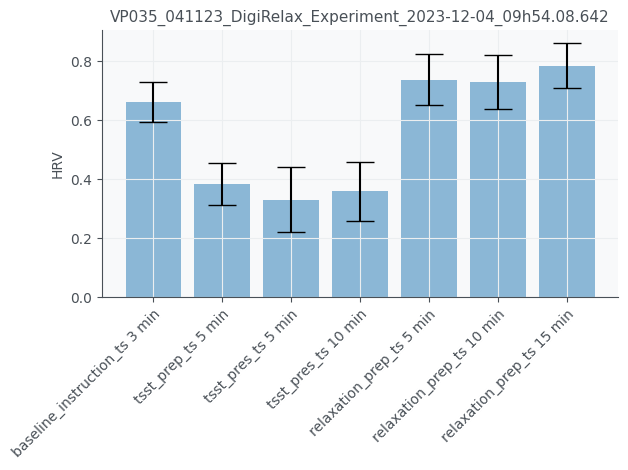

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP037_051223/Psychopy_data/VP037_051223_DigiRelax_Experiment_2023-12-05_10h01.53.815.csv
VP037_051223_DigiRelax_Experiment_2023-12-05_10h01.53.815
baseline_instruction_ts 3 min
{'Mean RR (ms)': 844.3979561611375, 'STD RR/SDNN (ms)': 44.6687764822782, 'Mean HR (beats/min)': 71.25464365582629, 'STD HR (beats/min)': 3.751558429888949, 'Min HR (beats/min)': 63.47107438016529, 'Max HR (beats/min)': 80.41884816753927, 'RMSSD (ms)': 59.88410534765206, 'NNxx': 111, 'pNNxx (%)': 52.60663507109005}
tsst_prep_ts 5 min
{'Mean RR (ms)': 511.9900173611111, 'STD RR/SDNN (ms)': 26.002586145560485, 'Mean HR (beats/min)': 117.4810100398133, 'STD HR (beats/min)': 5.7472136543123495, 'Min HR (beats/min)': 101.05263157894737, 'Max HR (beats/min)': 133.56521739130434, 'RMSSD (ms)': 13.6244811304273, 'NNxx': 13, 'pNNxx (%)': 2.2569444444444446}
tsst_pres_ts 5 min
{'Mean RR (ms)': 482.19079213938414, 'STD RR/SDNN (ms)': 13.423468286881489, 'Mean HR (beat

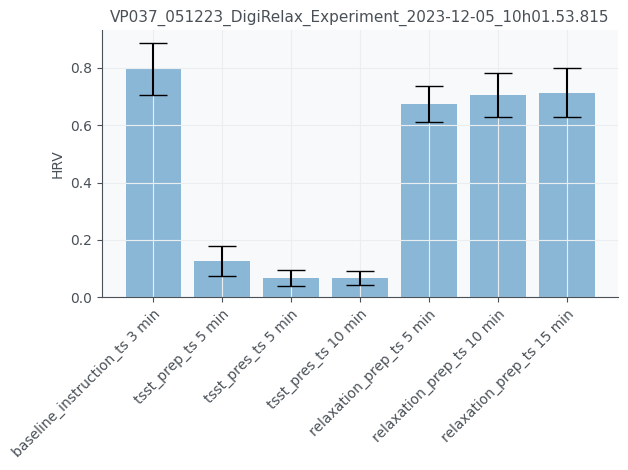

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP038_051223/Psychopy_data/VP038_051223_DigiRelax_Experiment_2023-12-05_15h52.43.156.csv
VP038_051223_DigiRelax_Experiment_2023-12-05_15h52.43.156
baseline_instruction_ts 3 min
{'Mean RR (ms)': 839.9721244131456, 'STD RR/SDNN (ms)': 42.41312257681965, 'Mean HR (beats/min)': 71.61222581321044, 'STD HR (beats/min)': 3.5974192590786, 'Min HR (beats/min)': 64.0, 'Max HR (beats/min)': 80.41884816753927, 'RMSSD (ms)': 33.8067699708989, 'NNxx': 27, 'pNNxx (%)': 12.67605633802817}
tsst_prep_ts 5 min
{'Mean RR (ms)': 808.4624915994624, 'STD RR/SDNN (ms)': 47.26684426552037, 'Mean HR (beats/min)': 74.47461677444461, 'STD HR (beats/min)': 4.459116247040628, 'Min HR (beats/min)': 64.0, 'Max HR (beats/min)': 89.30232558139535, 'RMSSD (ms)': 38.41191934504136, 'NNxx': 46, 'pNNxx (%)': 12.365591397849462}
tsst_pres_ts 5 min
{'Mean RR (ms)': 691.9842155612245, 'STD RR/SDNN (ms)': 78.7412463878199, 'Mean HR (beats/min)': 88.01097367991545, 'STD HR

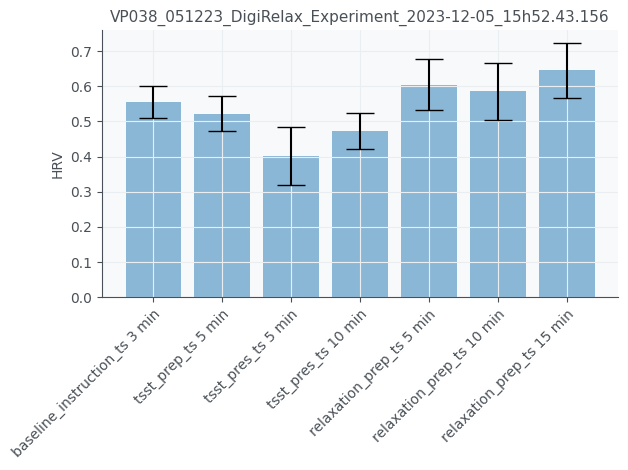

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP039_061223/Psychopy_data/VP039_061223_DigiRelax_Experiment_2023-12-06_09h56.18.635.csv
VP039_061223_DigiRelax_Experiment_2023-12-06_09h56.18.635
baseline_instruction_ts 3 min
{'Mean RR (ms)': 874.7632575757576, 'STD RR/SDNN (ms)': 48.652440196601724, 'Mean HR (beats/min)': 68.80178868259405, 'STD HR (beats/min)': 3.8153768251169455, 'Min HR (beats/min)': 60.0, 'Max HR (beats/min)': 77.57575757575758, 'RMSSD (ms)': 61.00868913770723, 'NNxx': 105, 'pNNxx (%)': 53.03030303030303}
tsst_prep_ts 5 min
{'Mean RR (ms)': 729.4484608208955, 'STD RR/SDNN (ms)': 68.50499621229012, 'Mean HR (beats/min)': 82.95894145294494, 'STD HR (beats/min)': 7.5680997912059125, 'Min HR (beats/min)': 62.18623481781376, 'Max HR (beats/min)': 103.08724832214764, 'RMSSD (ms)': 37.61491300105785, 'NNxx': 54, 'pNNxx (%)': 13.432835820895523}
tsst_pres_ts 5 min
{'Mean RR (ms)': 675.2111991626795, 'STD RR/SDNN (ms)': 47.47012521877461, 'Mean HR (beats/min)': 89.2

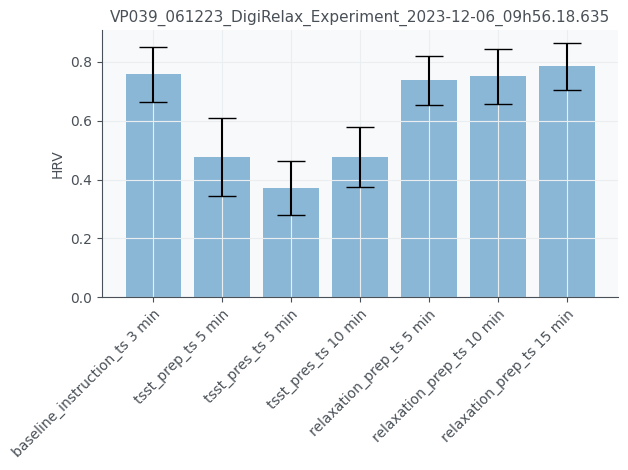

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP040_061223/Psychopy_data/VP040_061223_DigiRelax_Experiment_2023-12-06_13h18.31.319.csv
VP040_061223_DigiRelax_Experiment_2023-12-06_13h18.31.319
baseline_instruction_ts 3 min
{'Mean RR (ms)': 883.8954207920792, 'STD RR/SDNN (ms)': 65.94650756063932, 'Mean HR (beats/min)': 68.26684480076817, 'STD HR (beats/min)': 5.185624961822829, 'Min HR (beats/min)': 58.40304182509506, 'Max HR (beats/min)': 80.84210526315789, 'RMSSD (ms)': 63.266588767496366, 'NNxx': 104, 'pNNxx (%)': 51.48514851485149}
tsst_prep_ts 5 min
{'Mean RR (ms)': 656.0243055555555, 'STD RR/SDNN (ms)': 47.506773269315936, 'Mean HR (beats/min)': 91.93336047567861, 'STD HR (beats/min)': 6.561629481805172, 'Min HR (beats/min)': 77.1859296482412, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 33.86626627261872, 'NNxx': 56, 'pNNxx (%)': 12.444444444444445}
tsst_pres_ts 5 min
{'Mean RR (ms)': 592.2300277217741, 'STD RR/SDNN (ms)': 73.57679389433375, 'Mean HR (beats/

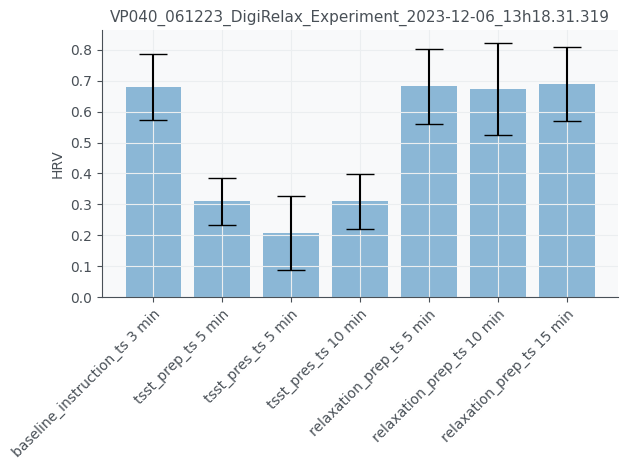

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP041_061223/Psychopy_data/VP041_061223_DigiRelax_Experiment_2023-12-06_15h50.23.237.csv
VP041_061223_DigiRelax_Experiment_2023-12-06_15h50.23.237
baseline_instruction_ts 3 min
{'Mean RR (ms)': 927.1240234375, 'STD RR/SDNN (ms)': 64.24645320587439, 'Mean HR (beats/min)': 65.02603705572487, 'STD HR (beats/min)': 4.485672831065768, 'Min HR (beats/min)': 55.85454545454545, 'Max HR (beats/min)': 77.1859296482412, 'RMSSD (ms)': 78.87098847311212, 'NNxx': 118, 'pNNxx (%)': 61.458333333333336}
tsst_prep_ts 5 min
{'Mean RR (ms)': 653.3548810840708, 'STD RR/SDNN (ms)': 53.98754842586341, 'Mean HR (beats/min)': 92.45480277067831, 'STD HR (beats/min)': 7.560730211422645, 'Min HR (beats/min)': 74.92682926829268, 'Max HR (beats/min)': 115.48872180451127, 'RMSSD (ms)': 38.60554160421454, 'NNxx': 73, 'pNNxx (%)': 16.150442477876105}
tsst_pres_ts 5 min
{'Mean RR (ms)': 832.275390625, 'STD RR/SDNN (ms)': 172.5050290482329, 'Mean HR (beats/min)': 7

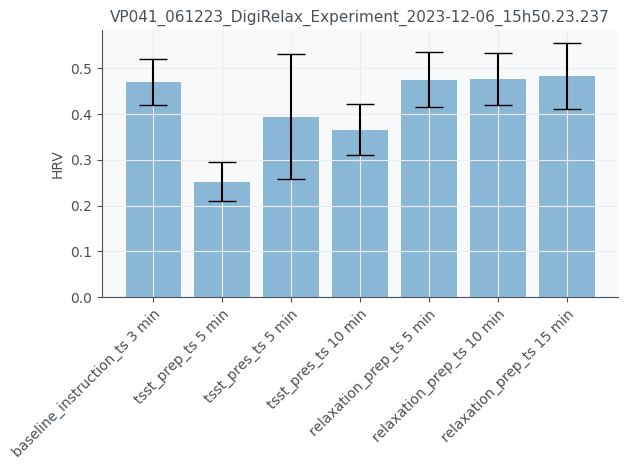

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP042_071223/Psychopy_data/VP042_071223_DigiRelax_Experiment_2023-12-07_10h46.20.248.csv
VP042_071223_DigiRelax_Experiment_2023-12-07_10h46.20.248
baseline_instruction_ts 3 min
{'Mean RR (ms)': 802.7606502242153, 'STD RR/SDNN (ms)': 42.69456503209235, 'Mean HR (beats/min)': 74.955062340635, 'STD HR (beats/min)': 4.014598021002456, 'Min HR (beats/min)': 66.20689655172414, 'Max HR (beats/min)': 85.81005586592178, 'RMSSD (ms)': 42.97834659420118, 'NNxx': 64, 'pNNxx (%)': 28.699551569506728}
tsst_prep_ts 5 min
{'Mean RR (ms)': 689.0226218097448, 'STD RR/SDNN (ms)': 46.79960700645028, 'Mean HR (beats/min)': 87.47200431611424, 'STD HR (beats/min)': 5.792968411880029, 'Min HR (beats/min)': 74.5631067961165, 'Max HR (beats/min)': 101.72185430463576, 'RMSSD (ms)': 41.08154137108804, 'NNxx': 84, 'pNNxx (%)': 19.48955916473318}
tsst_pres_ts 5 min
{'Mean RR (ms)': 545.1978211009174, 'STD RR/SDNN (ms)': 38.640760274966105, 'Mean HR (beats/min)

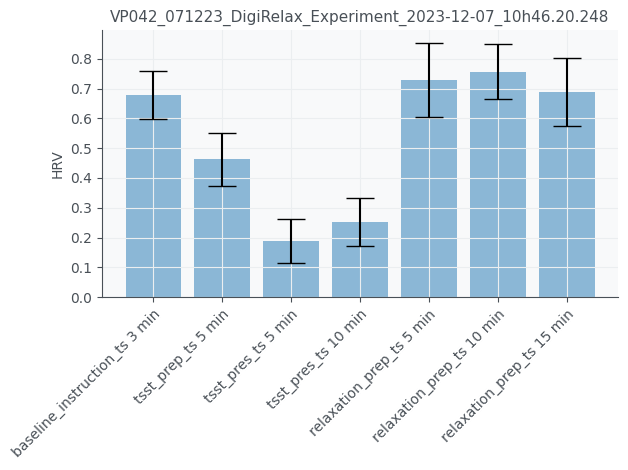

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP043_071223/Psychopy_data/VP043_071223_DigiRelax_Experiment_2023-12-07_13h24.11.749.csv
VP043_071223_DigiRelax_Experiment_2023-12-07_13h24.11.749
baseline_instruction_ts 3 min
{'Mean RR (ms)': 708.4762449186992, 'STD RR/SDNN (ms)': 47.11214769702443, 'Mean HR (beats/min)': 85.06550096600759, 'STD HR (beats/min)': 5.690573197248708, 'Min HR (beats/min)': 69.1891891891892, 'Max HR (beats/min)': 104.48979591836735, 'RMSSD (ms)': 61.59106690487564, 'NNxx': 135, 'pNNxx (%)': 54.8780487804878}
tsst_prep_ts 5 min
{'Mean RR (ms)': 733.4646002710027, 'STD RR/SDNN (ms)': 166.64259284098011, 'Mean HR (beats/min)': 84.48566335014984, 'STD HR (beats/min)': 12.175710830614133, 'Min HR (beats/min)': 43.63636363636363, 'Max HR (beats/min)': 133.56521739130434, 'RMSSD (ms)': 240.26871965306788, 'NNxx': 91, 'pNNxx (%)': 24.661246612466126}
tsst_pres_ts 5 min
{'Mean RR (ms)': 745.085685483871, 'STD RR/SDNN (ms)': 118.6656375140396, 'Mean HR (beats/

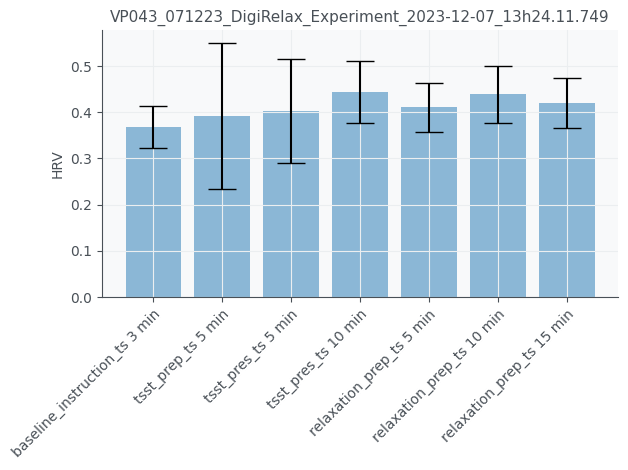

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP044_071223/Psychopy_data/VP044_071223_DigiRelax_Experiment_2023-12-07_15h47.55.663.csv
VP044_071223_DigiRelax_Experiment_2023-12-07_15h47.55.663
baseline_instruction_ts 3 min
{'Mean RR (ms)': 813.4944810779816, 'STD RR/SDNN (ms)': 109.2247071920527, 'Mean HR (beats/min)': 75.06066224852813, 'STD HR (beats/min)': 9.784361903511416, 'Min HR (beats/min)': 57.52808988764045, 'Max HR (beats/min)': 92.53012048192771, 'RMSSD (ms)': 86.5922523509621, 'NNxx': 119, 'pNNxx (%)': 54.58715596330275}
tsst_prep_ts 5 min
{'Mean RR (ms)': 572.0125120889749, 'STD RR/SDNN (ms)': 45.08380840566036, 'Mean HR (beats/min)': 105.53332007539512, 'STD HR (beats/min)': 8.166124219549893, 'Min HR (beats/min)': 86.77966101694915, 'Max HR (beats/min)': 124.8780487804878, 'RMSSD (ms)': 26.941734301034316, 'NNxx': 31, 'pNNxx (%)': 5.996131528046422}
tsst_pres_ts 5 min
{'Mean RR (ms)': 537.1838135208711, 'STD RR/SDNN (ms)': 44.93537359492037, 'Mean HR (beats/mi

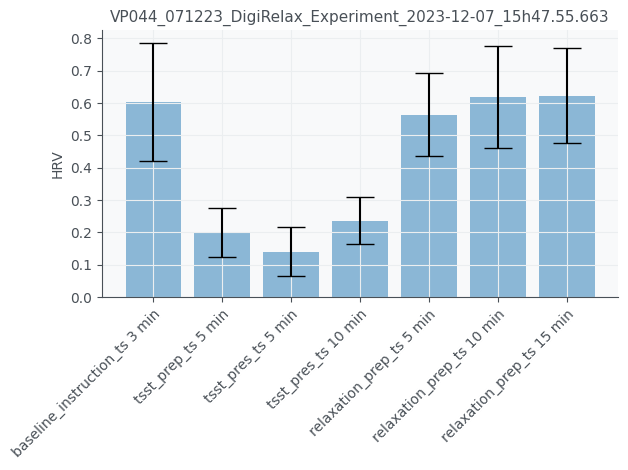

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP045_081223/Psychopy_data/VP045_081223_DigiRelax_Experiment_2023-12-08_09h50.13.039.csv
VP045_081223_DigiRelax_Experiment_2023-12-08_09h50.13.039
baseline_instruction_ts 3 min
{'Mean RR (ms)': 912.8727791878173, 'STD RR/SDNN (ms)': 49.1321246398175, 'Mean HR (beats/min)': 65.92031692408644, 'STD HR (beats/min)': 3.6089765170389447, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 76.8, 'RMSSD (ms)': 47.84729162792009, 'NNxx': 63, 'pNNxx (%)': 31.97969543147208}
tsst_prep_ts 5 min
{'Mean RR (ms)': 764.6710314910026, 'STD RR/SDNN (ms)': 66.85801067003106, 'Mean HR (beats/min)': 79.06465595733216, 'STD HR (beats/min)': 6.898806580788752, 'Min HR (beats/min)': 64.81012658227849, 'Max HR (beats/min)': 98.46153846153847, 'RMSSD (ms)': 46.699746888344116, 'NNxx': 94, 'pNNxx (%)': 24.164524421593832}
tsst_pres_ts 5 min
{'Mean RR (ms)': 632.3756720430108, 'STD RR/SDNN (ms)': 39.193406721395554, 'Mean HR (beats/min)': 95.2461

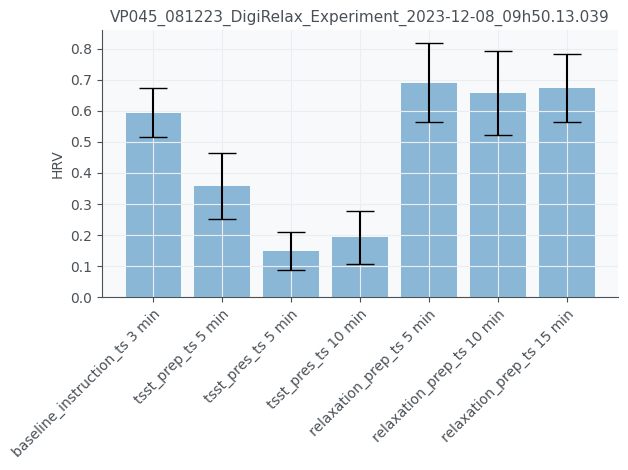

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP046_081223/Psychopy_data/Vp046_081223_DigiRelax_Experiment_2023-12-08_14h49.59.665.csv
Vp046_081223_DigiRelax_Experiment_2023-12-08_14h49.59.665
baseline_instruction_ts 3 min
{'Mean RR (ms)': 852.5390625, 'STD RR/SDNN (ms)': 57.61813331548153, 'Mean HR (beats/min)': 70.70642921800817, 'STD HR (beats/min)': 4.879362277628016, 'Min HR (beats/min)': 61.19521912350598, 'Max HR (beats/min)': 83.47826086956522, 'RMSSD (ms)': 41.909684882255426, 'NNxx': 43, 'pNNxx (%)': 20.476190476190474}
tsst_prep_ts 5 min
{'Mean RR (ms)': 641.8962149784483, 'STD RR/SDNN (ms)': 104.2985933842464, 'Mean HR (beats/min)': 96.00121735463654, 'STD HR (beats/min)': 15.688834204971808, 'Min HR (beats/min)': 70.45871559633028, 'Max HR (beats/min)': 126.94214876033058, 'RMSSD (ms)': 47.37885311271889, 'NNxx': 73, 'pNNxx (%)': 15.732758620689655}
tsst_pres_ts 5 min
{'Mean RR (ms)': 445.6079803328291, 'STD RR/SDNN (ms)': 21.510666253428923, 'Mean HR (beats/min)

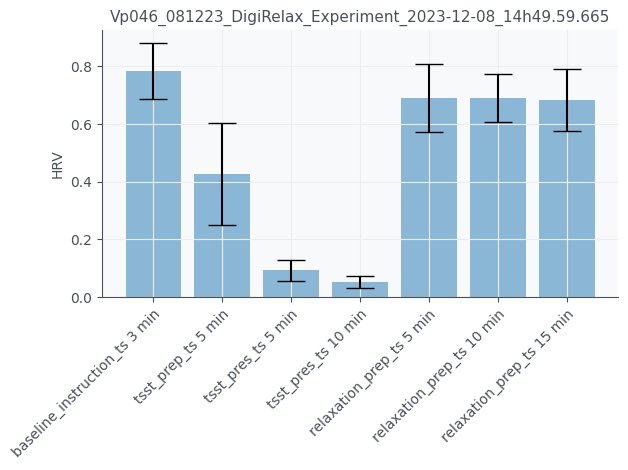

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP047_111223/Psychopy_data/VP047_111223_DigiRelax_Experiment_2023-12-11_14h40.20.997.csv
VP047_111223_DigiRelax_Experiment_2023-12-11_14h40.20.997
baseline_instruction_ts 3 min
{'Mean RR (ms)': 848.3511117788462, 'STD RR/SDNN (ms)': 58.88625050468936, 'Mean HR (beats/min)': 71.07432609445293, 'STD HR (beats/min)': 5.045622913450593, 'Min HR (beats/min)': 60.23529411764706, 'Max HR (beats/min)': 85.81005586592178, 'RMSSD (ms)': 64.0010714971068, 'NNxx': 108, 'pNNxx (%)': 51.92307692307692}
tsst_prep_ts 5 min
{'Mean RR (ms)': 670.7372572815534, 'STD RR/SDNN (ms)': 58.88914986030934, 'Mean HR (beats/min)': 90.25597100345645, 'STD HR (beats/min)': 9.589293355481841, 'Min HR (beats/min)': 70.13698630136986, 'Max HR (beats/min)': 168.7912087912088, 'RMSSD (ms)': 51.2082430698703, 'NNxx': 51, 'pNNxx (%)': 12.37864077669903}
tsst_pres_ts 5 min
{'Mean RR (ms)': 540.1223352713179, 'STD RR/SDNN (ms)': 100.86949803331996, 'Mean HR (beats/min)

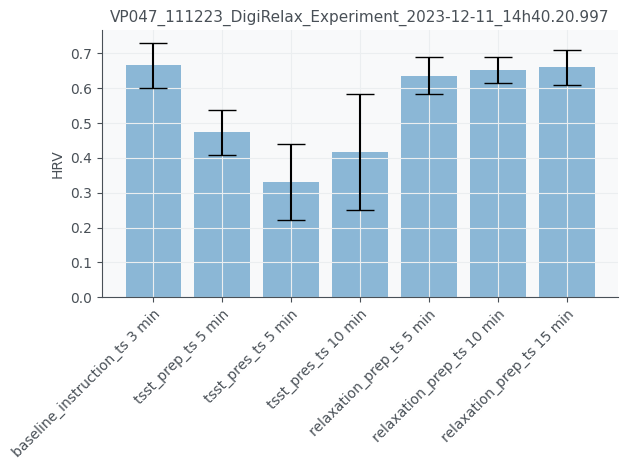

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP048_121223/Psychopy_data/VP048_121223_DigiRelax_Experiment_2023-12-12_09h46.06.539.csv
VP048_121223_DigiRelax_Experiment_2023-12-12_09h46.06.539
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1046.9431322674418, 'STD RR/SDNN (ms)': 76.85591902442974, 'Mean HR (beats/min)': 57.634087607626014, 'STD HR (beats/min)': 4.435997308727886, 'Min HR (beats/min)': 49.87012987012987, 'Max HR (beats/min)': 70.45871559633028, 'RMSSD (ms)': 97.56414699119975, 'NNxx': 110, 'pNNxx (%)': 63.95348837209303}
tsst_prep_ts 5 min
{'Mean RR (ms)': 883.1561583577712, 'STD RR/SDNN (ms)': 99.83062287208124, 'Mean HR (beats/min)': 68.8498511443612, 'STD HR (beats/min)': 8.130576904027889, 'Min HR (beats/min)': 55.25179856115108, 'Max HR (beats/min)': 90.3529411764706, 'RMSSD (ms)': 93.20965797946036, 'NNxx': 205, 'pNNxx (%)': 60.117302052785924}
tsst_pres_ts 5 min
{'Mean RR (ms)': 672.7361505681819, 'STD RR/SDNN (ms)': 79.66045191970893, 'Mean HR (beats/m

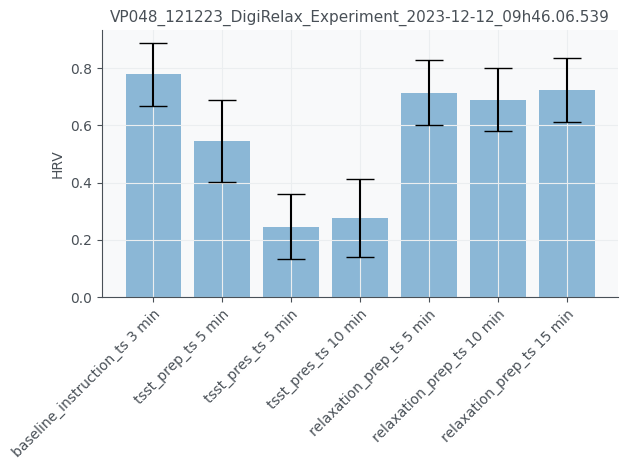

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP049_121223/Psychopy_data/VP049_121223_DigiRelax_Experiment_2023-12-12_13h41.48.891.csv
VP049_121223_DigiRelax_Experiment_2023-12-12_13h41.48.891
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1018.0220170454545, 'STD RR/SDNN (ms)': 47.1237769047299, 'Mean HR (beats/min)': 59.065594993722854, 'STD HR (beats/min)': 2.76500139893997, 'Min HR (beats/min)': 54.08450704225352, 'Max HR (beats/min)': 66.49350649350649, 'RMSSD (ms)': 51.87019260211357, 'NNxx': 70, 'pNNxx (%)': 39.77272727272727}
tsst_prep_ts 5 min
{'Mean RR (ms)': 791.7191700268817, 'STD RR/SDNN (ms)': 75.48323866584578, 'Mean HR (beats/min)': 76.47858287219745, 'STD HR (beats/min)': 7.329263485248556, 'Min HR (beats/min)': 61.44, 'Max HR (beats/min)': 94.81481481481481, 'RMSSD (ms)': 53.18722387039886, 'NNxx': 126, 'pNNxx (%)': 33.87096774193548}
tsst_pres_ts 5 min
{'Mean RR (ms)': 584.6691359561753, 'STD RR/SDNN (ms)': 35.690009402146636, 'Mean HR (beats/min)': 102.992

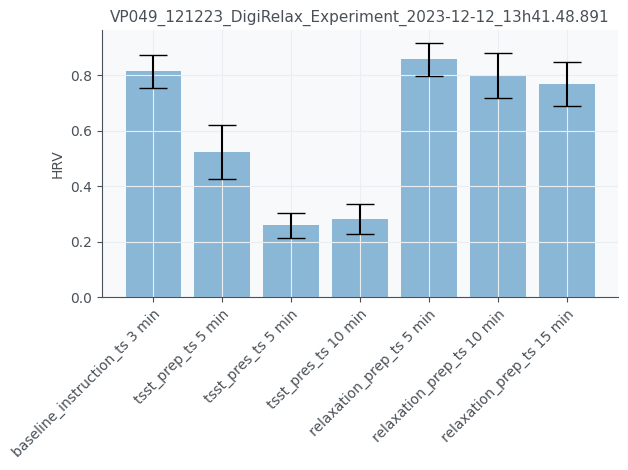

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP050_131223/Psychopy_data/VP050_131223_DigiRelax_Experiment_2023-12-13_09h49.36.277.csv
VP050_131223_DigiRelax_Experiment_2023-12-13_09h49.36.277
baseline_instruction_ts 3 min
{'Mean RR (ms)': 658.41213099631, 'STD RR/SDNN (ms)': 29.303816222749827, 'Mean HR (beats/min)': 91.30775201179833, 'STD HR (beats/min)': 4.039485868975916, 'Min HR (beats/min)': 82.13903743315508, 'Max HR (beats/min)': 101.05263157894737, 'RMSSD (ms)': 38.11717839659468, 'NNxx': 40, 'pNNxx (%)': 14.760147601476016}
tsst_prep_ts 5 min
{'Mean RR (ms)': 510.74397935779814, 'STD RR/SDNN (ms)': 57.89507530685874, 'Mean HR (beats/min)': 119.00367369618074, 'STD HR (beats/min)': 14.116124224284171, 'Min HR (beats/min)': 79.58549222797927, 'Max HR (beats/min)': 243.8095238095238, 'RMSSD (ms)': 47.23058726935352, 'NNxx': 79, 'pNNxx (%)': 14.495412844036696}
tsst_pres_ts 5 min
{'Mean RR (ms)': 451.6640253565769, 'STD RR/SDNN (ms)': 26.152530983316904, 'Mean HR (beat

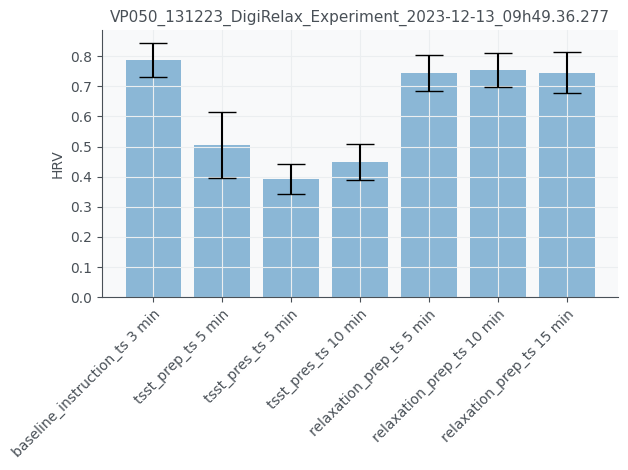

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP051_131223/Psychopy_data/VP051_131223_DigiRelax_Experiment_2023-12-13_13h12.46.570.csv
VP051_131223_DigiRelax_Experiment_2023-12-13_13h12.46.570
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1000.0759548611111, 'STD RR/SDNN (ms)': 38.35810421505764, 'Mean HR (beats/min)': 60.08660543096436, 'STD HR (beats/min)': 2.380473891993575, 'Min HR (beats/min)': 55.45126353790614, 'Max HR (beats/min)': 67.96460176991151, 'RMSSD (ms)': 38.5940508329996, 'NNxx': 30, 'pNNxx (%)': 16.666666666666668}
tsst_prep_ts 5 min
{'Mean RR (ms)': 638.758296460177, 'STD RR/SDNN (ms)': 71.58359607701898, 'Mean HR (beats/min)': 95.0449429418541, 'STD HR (beats/min)': 10.064339947781837, 'Min HR (beats/min)': 69.81818181818181, 'Max HR (beats/min)': 129.07563025210084, 'RMSSD (ms)': 49.109413585933765, 'NNxx': 50, 'pNNxx (%)': 11.061946902654867}
tsst_pres_ts 5 min
{'Mean RR (ms)': 479.69254846526655, 'STD RR/SDNN (ms)': 31.14908822625492, 'Mean HR (beats/

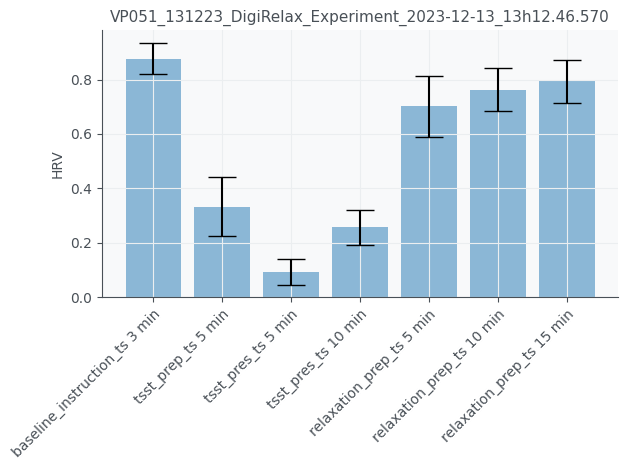

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP052_131223/Psychopy_data/VP052_131223_DigiRelax_Experiment_2023-12-13_15h40.02.531.csv
VP052_131223_DigiRelax_Experiment_2023-12-13_15h40.02.531
baseline_instruction_ts 3 min
{'Mean RR (ms)': 869.016768292683, 'STD RR/SDNN (ms)': 69.91601665830223, 'Mean HR (beats/min)': 69.48951867858557, 'STD HR (beats/min)': 5.565082680615685, 'Min HR (beats/min)': 59.07692307692308, 'Max HR (beats/min)': 82.58064516129032, 'RMSSD (ms)': 91.16566332780378, 'NNxx': 132, 'pNNxx (%)': 64.39024390243902}
tsst_prep_ts 5 min
{'Mean RR (ms)': 749.7025697969543, 'STD RR/SDNN (ms)': 55.42738610123835, 'Mean HR (beats/min)': 80.45512621066064, 'STD HR (beats/min)': 5.746617514049053, 'Min HR (beats/min)': 67.66519823788546, 'Max HR (beats/min)': 94.81481481481481, 'RMSSD (ms)': 52.75029431165485, 'NNxx': 128, 'pNNxx (%)': 32.48730964467005}
tsst_pres_ts 5 min
{'Mean RR (ms)': 679.955051369863, 'STD RR/SDNN (ms)': 29.37432993122746, 'Mean HR (beats/min)

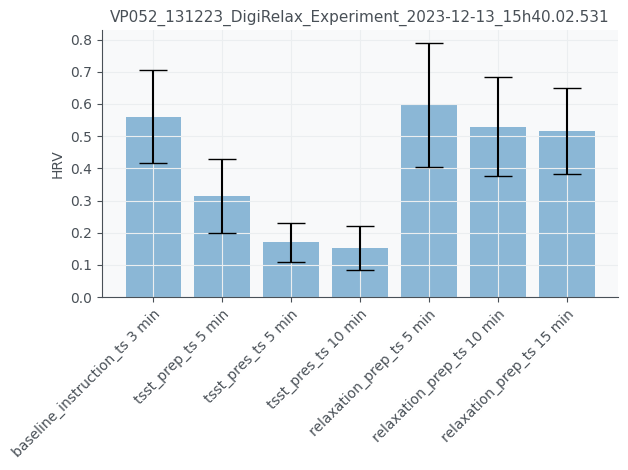

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP053_141223/Psychopy_data/VP053_141223_DigiRelax_Experiment_2023-12-14_09h43.01.217.csv
VP053_141223_DigiRelax_Experiment_2023-12-14_09h43.01.217
baseline_instruction_ts 3 min
{'Mean RR (ms)': 937.047697368421, 'STD RR/SDNN (ms)': 24.0688215133187, 'Mean HR (beats/min)': 64.07285064948269, 'STD HR (beats/min)': 1.6340422941566473, 'Min HR (beats/min)': 60.71146245059288, 'Max HR (beats/min)': 67.07423580786026, 'RMSSD (ms)': 12.466498798910653, 'NNxx': 2, 'pNNxx (%)': 1.0526315789473684}
tsst_prep_ts 5 min
{'Mean RR (ms)': 871.1840679190751, 'STD RR/SDNN (ms)': 42.183514444129756, 'Mean HR (beats/min)': 69.0427852414096, 'STD HR (beats/min)': 3.535161955515311, 'Min HR (beats/min)': 62.950819672131146, 'Max HR (beats/min)': 79.17525773195877, 'RMSSD (ms)': 28.948907273625313, 'NNxx': 32, 'pNNxx (%)': 9.248554913294798}
tsst_pres_ts 5 min
{'Mean RR (ms)': 705.7476359338061, 'STD RR/SDNN (ms)': 81.63635969788801, 'Mean HR (beats/mi

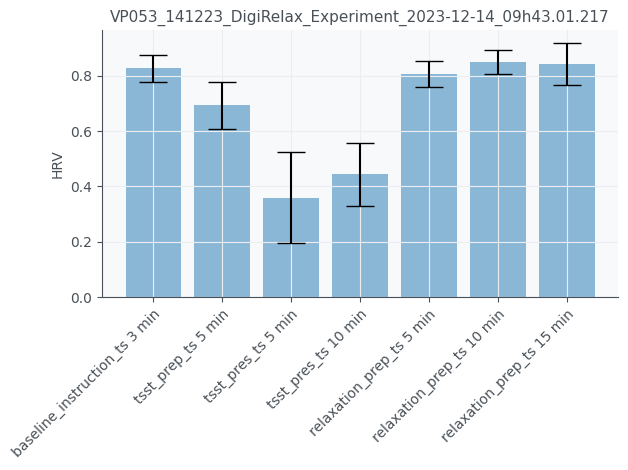

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP054_141223/Psychopy_data/VP054_141223_DigiRelax_Experiment_2023-12-14_13h16.33.883.csv
VP054_141223_DigiRelax_Experiment_2023-12-14_13h16.33.883
baseline_instruction_ts 3 min
{'Mean RR (ms)': 885.9452351485148, 'STD RR/SDNN (ms)': 55.234566469156526, 'Mean HR (beats/min)': 67.99076839962366, 'STD HR (beats/min)': 4.28873193125949, 'Min HR (beats/min)': 58.85057471264368, 'Max HR (beats/min)': 78.76923076923077, 'RMSSD (ms)': 51.20775612684705, 'NNxx': 68, 'pNNxx (%)': 33.663366336633665}
tsst_prep_ts 5 min
{'Mean RR (ms)': 644.4376361655774, 'STD RR/SDNN (ms)': 65.35357058672936, 'Mean HR (beats/min)': 94.06762841178848, 'STD HR (beats/min)': 9.565489537261806, 'Min HR (beats/min)': 74.92682926829268, 'Max HR (beats/min)': 117.25190839694656, 'RMSSD (ms)': 34.98811230783565, 'NNxx': 50, 'pNNxx (%)': 10.893246187363834}
tsst_pres_ts 5 min
{'Mean RR (ms)': 563.7473111854684, 'STD RR/SDNN (ms)': 39.417777784907145, 'Mean HR (beats/

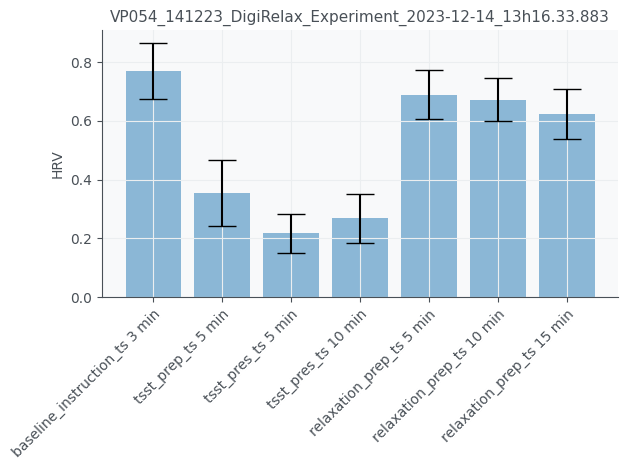

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP055_141223/Psychopy_data/VP055_141223_DigiRelax_Experiment_2023-12-14_15h45.35.483.csv
VP055_141223_DigiRelax_Experiment_2023-12-14_15h45.35.483
baseline_instruction_ts 3 min
{'Mean RR (ms)': 931.4168294270834, 'STD RR/SDNN (ms)': 62.41689229511892, 'Mean HR (beats/min)': 64.7061420305957, 'STD HR (beats/min)': 4.313886406107824, 'Min HR (beats/min)': 55.85454545454545, 'Max HR (beats/min)': 76.03960396039604, 'RMSSD (ms)': 79.39243103709597, 'NNxx': 98, 'pNNxx (%)': 51.041666666666664}
tsst_prep_ts 5 min
{'Mean RR (ms)': 643.5951116557734, 'STD RR/SDNN (ms)': 47.53474532798549, 'Mean HR (beats/min)': 93.73355261678321, 'STD HR (beats/min)': 6.899781405259903, 'Min HR (beats/min)': 77.96954314720813, 'Max HR (beats/min)': 112.94117647058823, 'RMSSD (ms)': 29.728388262601847, 'NNxx': 37, 'pNNxx (%)': 8.061002178649238}
tsst_pres_ts 5 min
{'Mean RR (ms)': 477.7161918138042, 'STD RR/SDNN (ms)': 39.284349610397314, 'Mean HR (beats/m

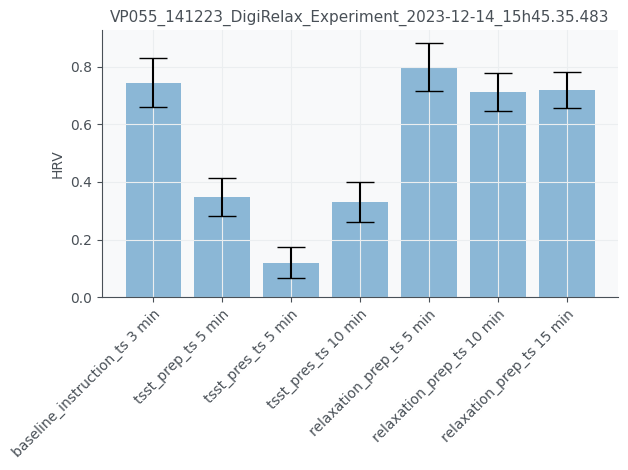

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP056_151223/Psychopy_data/VP056_151223_DigiRelax_Experiment_2023-12-15_09h45.05.317.csv
VP056_151223_DigiRelax_Experiment_2023-12-15_09h45.05.317
baseline_instruction_ts 3 min
{'Mean RR (ms)': 822.6634837962963, 'STD RR/SDNN (ms)': 42.484113977325634, 'Mean HR (beats/min)': 73.12855775002319, 'STD HR (beats/min)': 3.7768482252674493, 'Min HR (beats/min)': 64.81012658227849, 'Max HR (beats/min)': 81.70212765957447, 'RMSSD (ms)': 43.27897394527525, 'NNxx': 67, 'pNNxx (%)': 31.01851851851852}
tsst_prep_ts 5 min
{'Mean RR (ms)': 719.7592703349283, 'STD RR/SDNN (ms)': 66.46342168852155, 'Mean HR (beats/min)': 84.05987936348308, 'STD HR (beats/min)': 7.626368493196644, 'Min HR (beats/min)': 66.78260869565217, 'Max HR (beats/min)': 111.30434782608695, 'RMSSD (ms)': 62.392767159122556, 'NNxx': 124, 'pNNxx (%)': 29.66507177033493}
tsst_pres_ts 5 min
{'Mean RR (ms)': 654.1549077643172, 'STD RR/SDNN (ms)': 59.56926175839845, 'Mean HR (beats

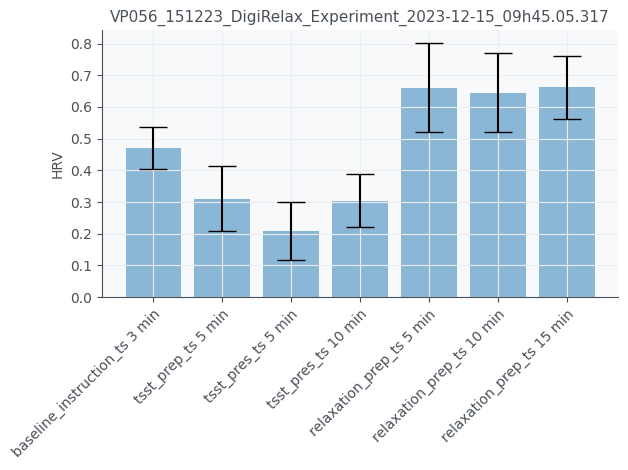

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP057_151223/Psychopy_data/VP057_151223_DigiRelax_Experiment_2023-12-15_15h00.46.722.csv
VP057_151223_DigiRelax_Experiment_2023-12-15_15h00.46.722
baseline_instruction_ts 3 min
{'Mean RR (ms)': 882.8125, 'STD RR/SDNN (ms)': 69.84545404800426, 'Mean HR (beats/min)': 68.39128742725924, 'STD HR (beats/min)': 5.420421439817575, 'Min HR (beats/min)': 57.52808988764045, 'Max HR (beats/min)': 83.02702702702703, 'RMSSD (ms)': 70.15146358642957, 'NNxx': 104, 'pNNxx (%)': 52.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 835.0656702898551, 'STD RR/SDNN (ms)': 166.61603710259297, 'Mean HR (beats/min)': 75.17093665959864, 'STD HR (beats/min)': 20.92729583551357, 'Min HR (beats/min)': 41.06951871657754, 'Max HR (beats/min)': 295.38461538461536, 'RMSSD (ms)': 195.47197795055823, 'NNxx': 181, 'pNNxx (%)': 52.46376811594203}
tsst_pres_ts 5 min
{'Mean RR (ms)': 746.3761295180723, 'STD RR/SDNN (ms)': 130.64707836107618, 'Mean HR (beats/min)': 83.9082784194

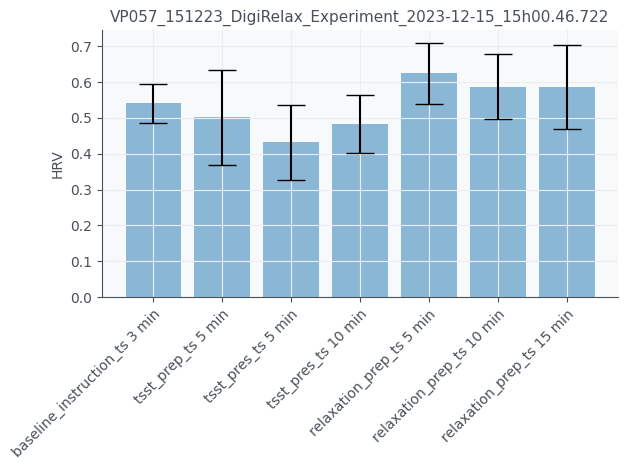

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP059_181223/Psychopy_data/VP059_181223_DigiRelax_Experiment_2023-12-18_14h46.34.198.csv
VP059_181223_DigiRelax_Experiment_2023-12-18_14h46.34.198
baseline_instruction_ts 3 min
{'Mean RR (ms)': 682.5351860687023, 'STD RR/SDNN (ms)': 24.240959008950785, 'Mean HR (beats/min)': 88.01738589755728, 'STD HR (beats/min)': 3.095598641489468, 'Min HR (beats/min)': 80.84210526315789, 'Max HR (beats/min)': 96.0, 'RMSSD (ms)': 22.387530621504094, 'NNxx': 9, 'pNNxx (%)': 3.435114503816794}
tsst_prep_ts 5 min
{'Mean RR (ms)': 639.3340933476395, 'STD RR/SDNN (ms)': 33.634539922737865, 'Mean HR (beats/min)': 94.11285664095146, 'STD HR (beats/min)': 5.056580508969217, 'Min HR (beats/min)': 81.70212765957447, 'Max HR (beats/min)': 109.71428571428571, 'RMSSD (ms)': 23.566652440999455, 'NNxx': 21, 'pNNxx (%)': 4.506437768240343}
tsst_pres_ts 5 min
{'Mean RR (ms)': 619.5279879958247, 'STD RR/SDNN (ms)': 38.064227344156855, 'Mean HR (beats/min)': 97.20

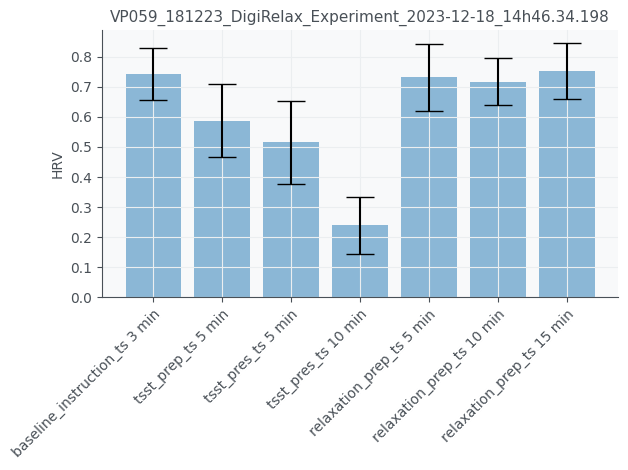

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP060_191223/Psychopy_data/VP060_191223_DigiRelax_Experiment_2023-12-19_09h48.26.679.csv
VP060_191223_DigiRelax_Experiment_2023-12-19_09h48.26.679
baseline_instruction_ts 3 min
{'Mean RR (ms)': 1102.2532393292684, 'STD RR/SDNN (ms)': 90.26109321727132, 'Mean HR (beats/min)': 54.81924826905554, 'STD HR (beats/min)': 4.737736280117513, 'Min HR (beats/min)': 45.98802395209581, 'Max HR (beats/min)': 68.57142857142857, 'RMSSD (ms)': 122.2683162165349, 'NNxx': 114, 'pNNxx (%)': 69.51219512195122}
tsst_prep_ts 5 min
{'Mean RR (ms)': 799.9343665311653, 'STD RR/SDNN (ms)': 108.40408196994512, 'Mean HR (beats/min)': 76.44445611456692, 'STD HR (beats/min)': 10.770078786747204, 'Min HR (beats/min)': 57.100371747211895, 'Max HR (beats/min)': 107.41258741258741, 'RMSSD (ms)': 69.11041716823, 'NNxx': 140, 'pNNxx (%)': 37.94037940379404}
tsst_pres_ts 5 min
{'Mean RR (ms)': 567.9462139423077, 'STD RR/SDNN (ms)': 61.3762841374495, 'Mean HR (beats/m

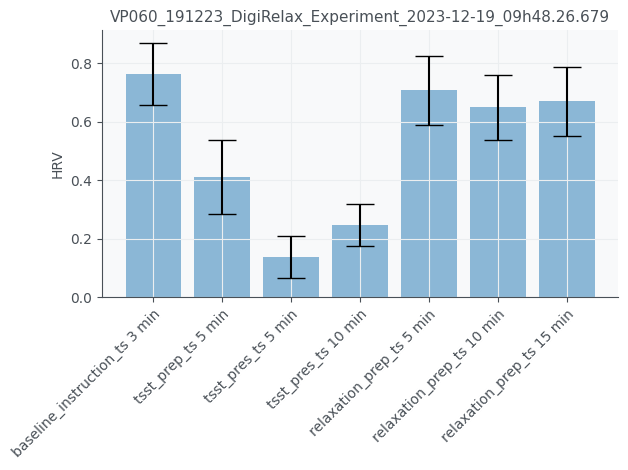

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP063_040124/Psychopy_data/VP063_040124_DigiRelax_Experiment_2024-01-04_14h59.12.423.csv
VP063_040124_DigiRelax_Experiment_2024-01-04_14h59.12.423
baseline_instruction_ts 3 min
{'Mean RR (ms)': 786.7118362831858, 'STD RR/SDNN (ms)': 33.20887843424353, 'Mean HR (beats/min)': 76.40002736587044, 'STD HR (beats/min)': 3.160819370488645, 'Min HR (beats/min)': 67.66519823788546, 'Max HR (beats/min)': 84.3956043956044, 'RMSSD (ms)': 27.494623448528785, 'NNxx': 17, 'pNNxx (%)': 7.522123893805309}
tsst_prep_ts 5 min
{'Mean RR (ms)': 711.9467703349283, 'STD RR/SDNN (ms)': 36.818832644605784, 'Mean HR (beats/min)': 84.50172556320891, 'STD HR (beats/min)': 4.3749124644036455, 'Min HR (beats/min)': 73.84615384615384, 'Max HR (beats/min)': 96.0, 'RMSSD (ms)': 23.658932246272716, 'NNxx': 19, 'pNNxx (%)': 4.545454545454546}
tsst_pres_ts 5 min
{'Mean RR (ms)': 646.5826723194748, 'STD RR/SDNN (ms)': 44.438269314538815, 'Mean HR (beats/min)': 93.249

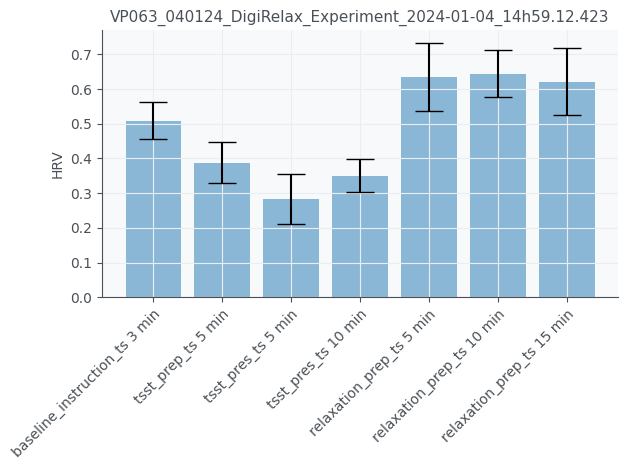

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP064_050124/Psychopy_data/VP064_050124_DigiRelax_Experiment_2024-01-05_09h44.11.070.csv
VP064_050124_DigiRelax_Experiment_2024-01-05_09h44.11.070
baseline_instruction_ts 3 min
{'Mean RR (ms)': 915.2844551282051, 'STD RR/SDNN (ms)': 38.911887074166245, 'Mean HR (beats/min)': 65.67204862016601, 'STD HR (beats/min)': 2.795313207858427, 'Min HR (beats/min)': 59.53488372093023, 'Max HR (beats/min)': 72.11267605633803, 'RMSSD (ms)': 43.57584249570736, 'NNxx': 53, 'pNNxx (%)': 27.17948717948718}
tsst_prep_ts 5 min
{'Mean RR (ms)': 559.9872509487666, 'STD RR/SDNN (ms)': 41.3177727659848, 'Mean HR (beats/min)': 107.71208162280189, 'STD HR (beats/min)': 7.70402459457738, 'Min HR (beats/min)': 89.82456140350877, 'Max HR (beats/min)': 123.87096774193549, 'RMSSD (ms)': 17.209966844788422, 'NNxx': 8, 'pNNxx (%)': 1.5180265654648957}
tsst_pres_ts 5 min
{'Mean RR (ms)': 636.1703563714902, 'STD RR/SDNN (ms)': 72.84569431160197, 'Mean HR (beats/mi

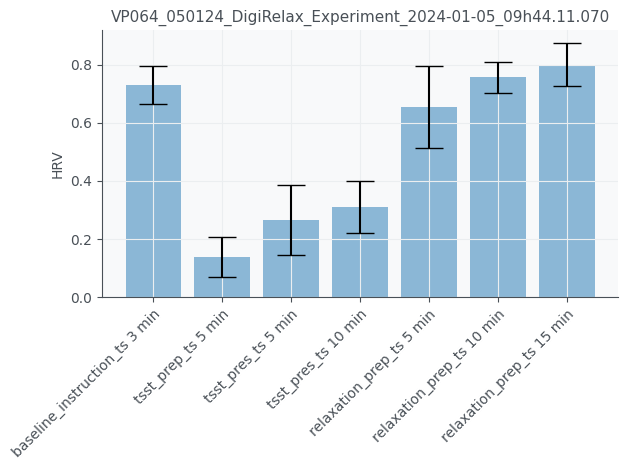

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP066_080124/Psychopy_data/VP066_080124_DigiRelax_Experiment_2024-01-08_13h36.32.476.csv
VP066_080124_DigiRelax_Experiment_2024-01-08_13h36.32.476
baseline_instruction_ts 3 min
{'Mean RR (ms)': 771.1688045851529, 'STD RR/SDNN (ms)': 61.49280313945159, 'Mean HR (beats/min)': 78.28912948206418, 'STD HR (beats/min)': 6.137506015686396, 'Min HR (beats/min)': 61.68674698795181, 'Max HR (beats/min)': 96.60377358490567, 'RMSSD (ms)': 64.57397876773031, 'NNxx': 80, 'pNNxx (%)': 34.93449781659389}
tsst_prep_ts 5 min
{'Mean RR (ms)': 633.7642346398305, 'STD RR/SDNN (ms)': 69.02599942257926, 'Mean HR (beats/min)': 95.77997422962964, 'STD HR (beats/min)': 10.23128976422476, 'Min HR (beats/min)': 75.29411764705883, 'Max HR (beats/min)': 125.90163934426229, 'RMSSD (ms)': 44.37377289185032, 'NNxx': 83, 'pNNxx (%)': 17.584745762711865}
tsst_pres_ts 5 min
{'Mean RR (ms)': 580.711468446602, 'STD RR/SDNN (ms)': 63.86443276957993, 'Mean HR (beats/min

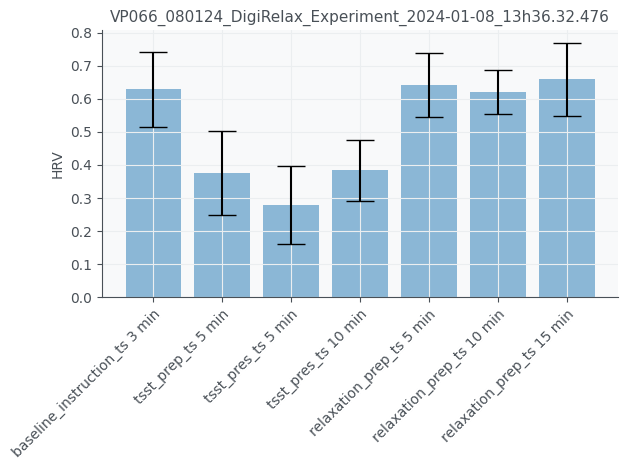

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP067_100124/Psychopy_data/VP067_100124_DigiRelax_Experiment_2024-01-10_09h51.01.071.csv
VP067_100124_DigiRelax_Experiment_2024-01-10_09h51.01.071
baseline_instruction_ts 3 min
{'Mean RR (ms)': 784.2786343612335, 'STD RR/SDNN (ms)': 29.37797586400922, 'Mean HR (beats/min)': 76.60985996319972, 'STD HR (beats/min)': 2.844436703416292, 'Min HR (beats/min)': 70.13698630136986, 'Max HR (beats/min)': 83.02702702702703, 'RMSSD (ms)': 25.80669249417558, 'NNxx': 10, 'pNNxx (%)': 4.405286343612334}
tsst_prep_ts 5 min
{'Mean RR (ms)': 654.254230349345, 'STD RR/SDNN (ms)': 55.103967467608754, 'Mean HR (beats/min)': 92.37901323574201, 'STD HR (beats/min)': 8.019370225101477, 'Min HR (beats/min)': 77.1859296482412, 'Max HR (beats/min)': 114.6268656716418, 'RMSSD (ms)': 28.59249072031839, 'NNxx': 24, 'pNNxx (%)': 5.240174672489083}
tsst_pres_ts 5 min
{'Mean RR (ms)': 631.546052631579, 'STD RR/SDNN (ms)': 47.93687316076676, 'Mean HR (beats/min)':

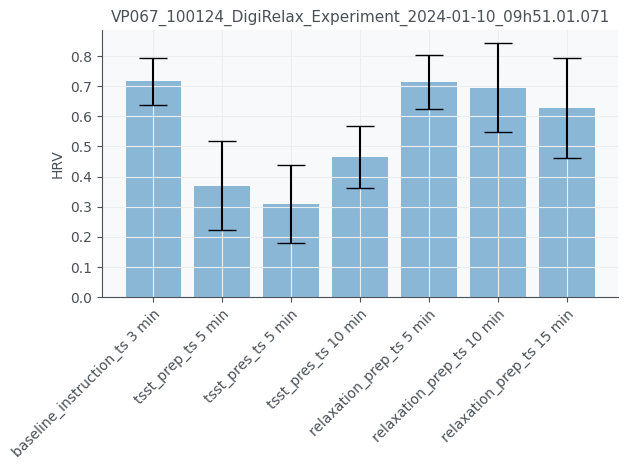

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP068_100124/Psychopy_data/VP068_100124_DigiRelax_Experiment_2024-01-10_14h41.55.244.csv
VP068_100124_DigiRelax_Experiment_2024-01-10_14h41.55.244
baseline_instruction_ts 3 min
{'Mean RR (ms)': 934.9917763157895, 'STD RR/SDNN (ms)': 101.23685107019016, 'Mean HR (beats/min)': 64.95151475270077, 'STD HR (beats/min)': 7.265343583916686, 'Min HR (beats/min)': 52.244897959183675, 'Max HR (beats/min)': 83.93442622950819, 'RMSSD (ms)': 86.44658539782118, 'NNxx': 105, 'pNNxx (%)': 55.26315789473684}
tsst_prep_ts 5 min
{'Mean RR (ms)': 739.3994140625, 'STD RR/SDNN (ms)': 79.48042334033472, 'Mean HR (beats/min)': 82.09611278540324, 'STD HR (beats/min)': 8.89722495378046, 'Min HR (beats/min)': 65.36170212765957, 'Max HR (beats/min)': 102.4, 'RMSSD (ms)': 45.03018044092619, 'NNxx': 95, 'pNNxx (%)': 23.75}
tsst_pres_ts 5 min
{'Mean RR (ms)': 538.5340493601462, 'STD RR/SDNN (ms)': 70.38902597977201, 'Mean HR (beats/min)': 113.22748666810479, 'S

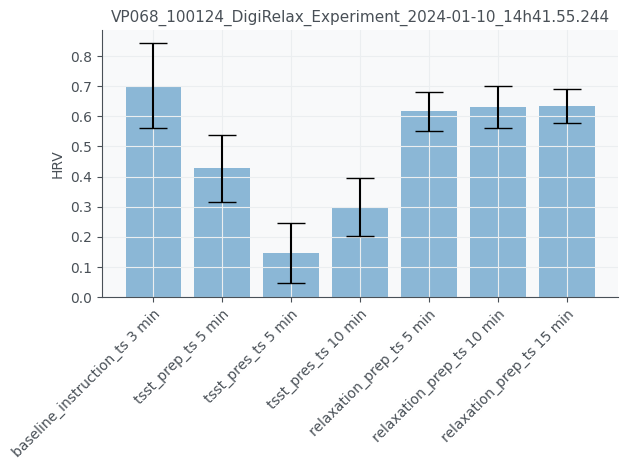

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP069_110124/Psychopy_data/VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639.csv
VP069_110124_DigiRelax_Experiment_2024-01-11_09h51.14.639
baseline_instruction_ts 3 min
{'Mean RR (ms)': 824.6366279069767, 'STD RR/SDNN (ms)': 48.44053254913207, 'Mean HR (beats/min)': 73.01046364646827, 'STD HR (beats/min)': 4.286991643621182, 'Min HR (beats/min)': 63.7344398340249, 'Max HR (beats/min)': 83.93442622950819, 'RMSSD (ms)': 41.614916266179385, 'NNxx': 59, 'pNNxx (%)': 27.441860465116278}
tsst_prep_ts 5 min
{'Mean RR (ms)': 609.495069159836, 'STD RR/SDNN (ms)': 43.11351291762911, 'Mean HR (beats/min)': 98.92945803642966, 'STD HR (beats/min)': 6.914442104716465, 'Min HR (beats/min)': 83.02702702702703, 'Max HR (beats/min)': 118.15384615384616, 'RMSSD (ms)': 26.763515910600116, 'NNxx': 31, 'pNNxx (%)': 6.352459016393443}
tsst_pres_ts 5 min
{'Mean RR (ms)': 722.035015060241, 'STD RR/SDNN (ms)': 67.43328526851144, 'Mean HR (beats/min

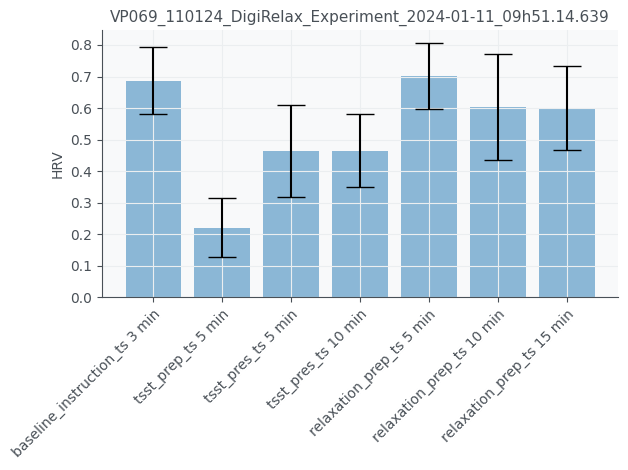

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP070_110124/Psychopy_data/VP070_110124_DigiRelax_Experiment_2024-01-11_14h48.50.074.csv
VP070_110124_DigiRelax_Experiment_2024-01-11_14h48.50.074
baseline_instruction_ts 3 min
{'Mean RR (ms)': 886.6413985148515, 'STD RR/SDNN (ms)': 35.06795929211717, 'Mean HR (beats/min)': 67.77744849937416, 'STD HR (beats/min)': 2.692243643895162, 'Min HR (beats/min)': 61.935483870967744, 'Max HR (beats/min)': 74.92682926829268, 'RMSSD (ms)': 32.4898347603759, 'NNxx': 29, 'pNNxx (%)': 14.356435643564357}
tsst_prep_ts 5 min
{'Mean RR (ms)': 683.2295308857808, 'STD RR/SDNN (ms)': 58.21656178873183, 'Mean HR (beats/min)': 88.45934568732552, 'STD HR (beats/min)': 7.570938349704334, 'Min HR (beats/min)': 70.78341013824885, 'Max HR (beats/min)': 108.16901408450704, 'RMSSD (ms)': 33.75315365263293, 'NNxx': 54, 'pNNxx (%)': 12.587412587412587}
tsst_pres_ts 5 min
{'Mean RR (ms)': 668.6637809684685, 'STD RR/SDNN (ms)': 56.877956298425104, 'Mean HR (beats/

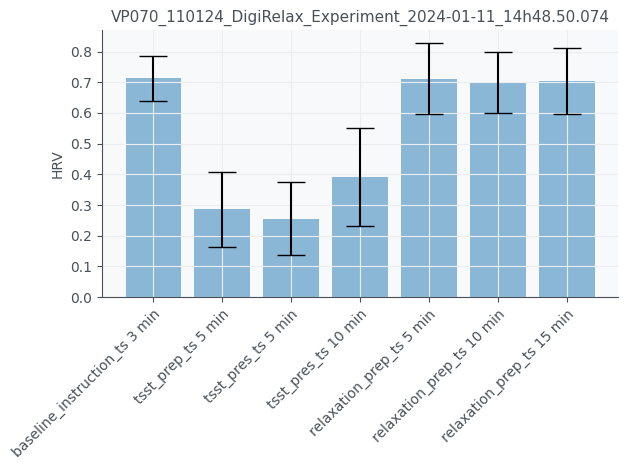

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP071_120124/Psychopy_data/VP071_120124_DigiRelax_Experiment_2024-01-12_09h48.13.466.csv
VP071_120124_DigiRelax_Experiment_2024-01-12_09h48.13.466
baseline_instruction_ts 3 min
{'Mean RR (ms)': 869.1595873786408, 'STD RR/SDNN (ms)': 53.90134095640774, 'Mean HR (beats/min)': 69.30132354477124, 'STD HR (beats/min)': 4.350091458683906, 'Min HR (beats/min)': 60.71146245059288, 'Max HR (beats/min)': 80.0, 'RMSSD (ms)': 58.638829203833374, 'NNxx': 103, 'pNNxx (%)': 50.0}
tsst_prep_ts 5 min
{'Mean RR (ms)': 732.48291015625, 'STD RR/SDNN (ms)': 140.09807997697575, 'Mean HR (beats/min)': 89.18463051536423, 'STD HR (beats/min)': 59.198572347812224, 'Min HR (beats/min)': 31.540041067761805, 'Max HR (beats/min)': 768.0, 'RMSSD (ms)': 173.79430955429513, 'NNxx': 76, 'pNNxx (%)': 23.75}
tsst_pres_ts 5 min
{'Mean RR (ms)': 568.0729166666666, 'STD RR/SDNN (ms)': 54.06115238250664, 'Mean HR (beats/min)': 106.58023232402462, 'STD HR (beats/min)': 1

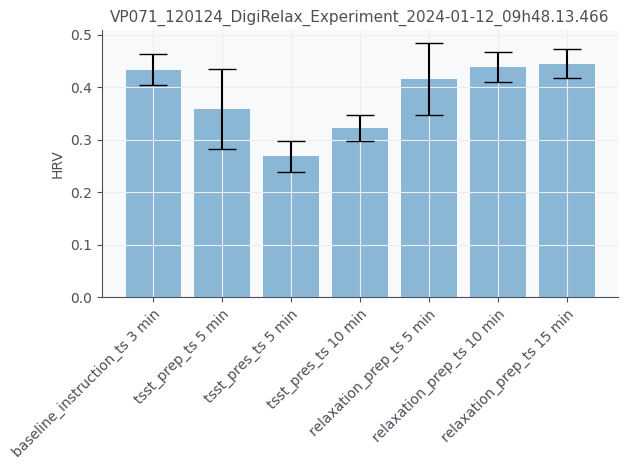

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP072_120124/Psychopy_data/VP072_120124_DigiRelax_Experiment_2024-01-12_14h45.23.547.csv
VP072_120124_DigiRelax_Experiment_2024-01-12_14h45.23.547
baseline_instruction_ts 3 min
{'Mean RR (ms)': 951.8298796791444, 'STD RR/SDNN (ms)': 47.224842578913595, 'Mean HR (beats/min)': 63.19299647359393, 'STD HR (beats/min)': 3.161866543848064, 'Min HR (beats/min)': 56.470588235294116, 'Max HR (beats/min)': 71.77570093457943, 'RMSSD (ms)': 53.88125564972911, 'NNxx': 76, 'pNNxx (%)': 40.64171122994652}
tsst_prep_ts 5 min
{'Mean RR (ms)': 671.9190886004515, 'STD RR/SDNN (ms)': 82.11013980709342, 'Mean HR (beats/min)': 90.67302070908927, 'STD HR (beats/min)': 11.365945633208163, 'Min HR (beats/min)': 70.78341013824885, 'Max HR (beats/min)': 120.0, 'RMSSD (ms)': 52.92371765988437, 'NNxx': 111, 'pNNxx (%)': 25.056433408577877}
tsst_pres_ts 5 min
{'Mean RR (ms)': 728.8616884101941, 'STD RR/SDNN (ms)': 94.2576501415647, 'Mean HR (beats/min)': 83.80

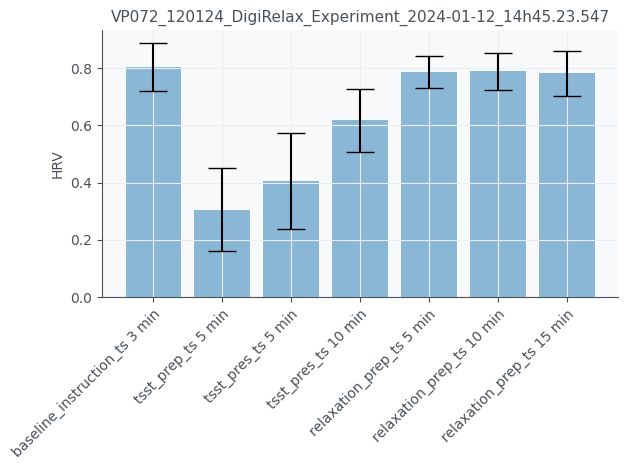

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP073_150124/Psychopy_data/VP073_150124_DigiRelax_Experiment_2024-01-15_10h17.11.190.csv
VP073_150124_DigiRelax_Experiment_2024-01-15_10h17.11.190
baseline_instruction_ts 3 min
{'Mean RR (ms)': 889.2257462686567, 'STD RR/SDNN (ms)': 44.348680362836596, 'Mean HR (beats/min)': 67.64015883708848, 'STD HR (beats/min)': 3.329388731379044, 'Min HR (beats/min)': 60.47244094488189, 'Max HR (beats/min)': 76.41791044776119, 'RMSSD (ms)': 39.922180771823136, 'NNxx': 41, 'pNNxx (%)': 20.398009950248756}
tsst_prep_ts 5 min
{'Mean RR (ms)': 793.0723640583554, 'STD RR/SDNN (ms)': 62.09059284448889, 'Mean HR (beats/min)': 76.13045654445831, 'STD HR (beats/min)': 6.099775903790912, 'Min HR (beats/min)': 64.0, 'Max HR (beats/min)': 93.65853658536585, 'RMSSD (ms)': 42.20931118355396, 'NNxx': 74, 'pNNxx (%)': 19.628647214854112}
tsst_pres_ts 5 min
{'Mean RR (ms)': 554.316183460076, 'STD RR/SDNN (ms)': 63.840295375075186, 'Mean HR (beats/min)': 109.61

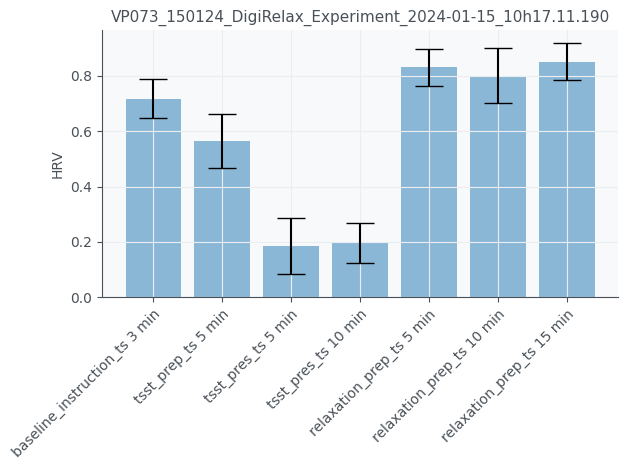

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP074_170124/Psychopy_data/VP074_170124_DigiRelax_Experiment_2024-01-17_09h52.17.376.csv
VP074_170124_DigiRelax_Experiment_2024-01-17_09h52.17.376
baseline_instruction_ts 3 min
{'Mean RR (ms)': 941.1184210526316, 'STD RR/SDNN (ms)': 66.48056528909964, 'Mean HR (beats/min)': 64.0829407716515, 'STD HR (beats/min)': 4.673503491792454, 'Min HR (beats/min)': 55.65217391304348, 'Max HR (beats/min)': 75.29411764705883, 'RMSSD (ms)': 63.033156057804, 'NNxx': 86, 'pNNxx (%)': 45.26315789473684}
tsst_prep_ts 5 min
{'Mean RR (ms)': 660.33935546875, 'STD RR/SDNN (ms)': 57.2988708928972, 'Mean HR (beats/min)': 91.54057760979275, 'STD HR (beats/min)': 7.869375333733261, 'Min HR (beats/min)': 73.49282296650718, 'Max HR (beats/min)': 115.48872180451127, 'RMSSD (ms)': 40.60545060192917, 'NNxx': 69, 'pNNxx (%)': 15.401785714285714}
tsst_pres_ts 5 min
{'Mean RR (ms)': 582.875, 'STD RR/SDNN (ms)': 55.38414322089401, 'Mean HR (beats/min)': 103.8238867

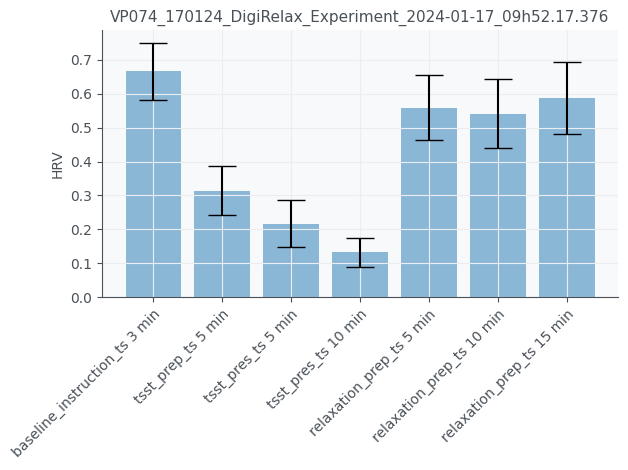

/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP075_180124/Psychopy_data/VP075_180124_DigiRelax_Experiment_2024-01-18_09h54.07.734.csv
VP075_180124_DigiRelax_Experiment_2024-01-18_09h54.07.734
baseline_instruction_ts 3 min
{'Mean RR (ms)': 945.811170212766, 'STD RR/SDNN (ms)': 57.969816448170036, 'Mean HR (beats/min)': 63.677440845489826, 'STD HR (beats/min)': 3.921660171700368, 'Min HR (beats/min)': 56.058394160583944, 'Max HR (beats/min)': 72.11267605633803, 'RMSSD (ms)': 76.39823827099964, 'NNxx': 114, 'pNNxx (%)': 60.638297872340424}
tsst_prep_ts 5 min
{'Mean RR (ms)': 813.004378434066, 'STD RR/SDNN (ms)': 53.83573839019647, 'Mean HR (beats/min)': 74.12806445295476, 'STD HR (beats/min)': 4.969855070024635, 'Min HR (beats/min)': 62.4390243902439, 'Max HR (beats/min)': 88.78612716763006, 'RMSSD (ms)': 50.56764980993556, 'NNxx': 114, 'pNNxx (%)': 31.318681318681318}
tsst_pres_ts 5 min
{'Mean RR (ms)': 788.3313836898395, 'STD RR/SDNN (ms)': 66.44092240147884, 'Mean HR (beats/

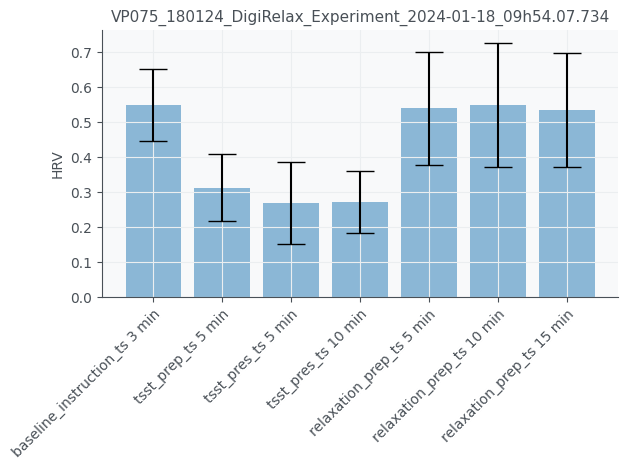

In [55]:
for sub_dir in sub_dirs:
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy_data")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    print(psychopy_file_path)
    
    fol_path, file_name_ii=os.path.split(psychopy_file_path)
    
    sub_id=file_name_ii[:-4]
    
    
    psychopy_df = read_manipulate_psychopy(psychopy_file_path)
    
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer_data")
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    #print(shimmer_files_name)
    
    for sh_file in shimmer_files_name:
        
        if '_6B1E_' in sh_file:
            hr_shimmer_path = sh_file
            
    fol_path, file_name=os.path.split(psychopy_file_path)
    sub_id=file_name[:-4]
    print(sub_id)
    
    ## heart rate
    timestamp_hr_col = "Shimmer_6B1E_Timestamp_Unix_CAL"
    ecg_col_name = "Shimmer_6B1E_ECG_LL-LA_24BIT_CAL"
    
    hr_df=read_shimmer_sensor(hr_shimmer_path)
    hr_df = standardize_timestamps_shimmer(hr_df, timestamp_hr_col)
    
    
    selected_ecg_df = hr_df[[timestamp_hr_col, ecg_col_name]]
    selected_ecg_df = selected_ecg_df.copy()
    selected_ecg_df['heartrate'] = selected_ecg_df[ecg_col_name]
    selected_ecg_df=col_from_str_float(selected_ecg_df, "heartrate")
    
    #selected_ecg_df =  normalize_data_min_max (selected_ecg_df, "heartrate")
    
    
    
    
    
    mean_hrv_list,std_hrv_list, event_interets_plot, all_rr_one_list, all_rr_sublist =  get_mean_std_event_list(psychopy_df, selected_ecg_df, event_interest_list_new, offset_min_list_new, timestamp_hr_col, "heartrate")
    
    norm_mean_hrv, norm_std_hrv = min_max_norm(all_rr_one_list, all_rr_sublist)
    
    ####-----Plot HRV ----------------------------------
    title_figure = "HRV"
    y_label_fig = "HRV"
    fig_hrv=plot_mean_std(norm_mean_hrv, norm_std_hrv, event_interets_plot, sub_id, y_label_fig)
    
    ##### save figure
    name_hrv = "hrv_" + sub_id + ".png" 
    dest_path_fig_hr = os.path.join(dest_path, name_hrv)
    fig_hrv.savefig(dest_path_fig_hr)
    
    #####---------------------Uncomment below for csv --------------------------------------
    #export_dict= {"subject_id":sub_id , 'event_interst': event_interets_plot, "mean_hrv":mean_hrv_list , "std_hrv": std_hrv_list , "norm_mean_hrv":norm_mean_hrv,  "norm_std_hrv": norm_std_hrv}
    #df_export = pd.DataFrame.from_dict(export_dict)
    
    #dest_path_csv = os.path.join(comp_dest_path,file_name_ii)
    ##df_export.to_csv(dest_path_csv)
    ####-------------till here-----------------------------------
    
    
    
    #####################################################################
   ##### uncomment the code below for differrent analysis for raw IBI in msecs 
   #################################################################### 
    

    
    hrv_data_dict = {}
    
    
    hrv_data_dict["subject_id"] = sub_id
    
    hrv_data_dict["event_interst"] = event_interets_plot
    
    hrv_data_dict["all_rr_one_list"] = all_rr_one_list
    
    hrv_data_dict["all_rr_sublists"] = all_rr_sublist
    

    

    pkl_file_hrv = sub_id + ".pkl"
    
    dest_path_csv_hrv = os.path.join(dest_path, pkl_file_hrv)
    with open(dest_path_csv_hrv, "wb") as f:
        pickle.dump(hrv_data_dict, f)
        f.close()
        
    ########################################################
    ####### till here ######################################
    ########################################################
    
        
    
    


In [14]:
hrv_data_dict

{'subject_id': 'VP004_081123_DigiRelax_Experiment_2023-11-08_10h28.36.317',
 'event_interst': ['baseline_instruction_ts 3 min',
  'tsst_prep_ts 5 min',
  'tsst_pres_ts 5 min',
  'tsst_pres_ts 10 min',
  'relaxation_prep_ts 5 min',
  'relaxation_prep_ts 10 min',
  'relaxation_prep_ts 15 min'],
 'all_rr_one_list': [1046.875,
  1027.34375,
  1066.40625,
  1039.0625,
  972.65625,
  1039.0625,
  1093.75,
  1082.03125,
  1035.15625,
  1035.15625,
  1117.1875,
  1011.71875,
  1019.53125,
  1015.625,
  976.5625,
  957.03125,
  1035.15625,
  953.125,
  968.75,
  984.375,
  1000.0,
  1003.90625,
  1003.90625,
  1003.90625,
  984.375,
  972.65625,
  976.5625,
  1003.90625,
  984.375,
  992.1875,
  1015.625,
  980.46875,
  1011.71875,
  1042.96875,
  996.09375,
  1050.78125,
  1066.40625,
  1023.4375,
  1097.65625,
  1117.1875,
  1035.15625,
  1117.1875,
  1054.6875,
  1046.875,
  1085.9375,
  1070.3125,
  1035.15625,
  1062.5,
  1054.6875,
  1089.84375,
  1054.6875,
  1105.46875,
  1042.96875,
  

In [15]:
len(all_rr_one_list)

2236

In [18]:
len(all_rr_sublist)

7